# Time Series Exploration of El Ninos and La Ninas
### By: Andrew Caietti
### Date: 3/5/2021

# 1 Introduction
For this lab, we will be exploring the data sets the paper mentioned below examined as well as recreate the observations the paper made. This will be done by sourcing each data set from the listed source in the paper, then analyzing time series attributes of the data set through methods we have observed in class: spectral density, periodigram, and autocorrelation function plots. 



## 1.1 Paper Background


### 1.1.1 Objective
The purpose of the paper (Lam et al., 2019) is to explore how the El Nino Southern Oscillation (ENSO), which is a driver of climatic variability, can have public health implications globally. To better understand this relationship, the study looks at natural disasters effects on people at a global, regional, and country level. 



### 1.1.2 Methods
The study started by acquiring three different data sets: the International Disasters Database (EMDAT), Oceanic Nino Index (ONI), and El Nino Index (MEI). From this, the study calculates an annual rate of People Affected by Disasters (PAD), and time-series regression is done on this data to assess detrended associations between the PAD and El Nino/La Nina datasets.



### 1.1.3 Results
It was found that 95% of PAD were caused by floods, droughts or storms, where 75% of people affected by these disasters resided in Asia. Of these disasters, floods were found to be most associated with El Nino, where flood-related PAD increased by 40.5% for each boundary point increase in ONI for the South Asia region. Lastly, India was identified as the country with the largest increase in flood-related PAD rates following an El Nino event, while Philippines was found to have the same record for La Nina events.


## 1.2 Packages Needed
For this paper, the following packages were installed:
 - 'tswge' (Woodward, 2016)
 - 'reshape' (Wickham, 2007)

# 2 Methods


## 2.1 Data Collection

Next, we can download each of the three data sets and re-create the plot seen in Figure 1 from the paper to then be analyzed in R (R Core Team, 2021).

### 2.1.1 ONI - Data
Below, I download the Oceanic Nino Index (ONI) dataset. This data set can be retrieved from the [NOAA Website](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php).

In [ ]:
url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(url, '/')), n=1)
oni.file <- paste('/tmp/', oni.name, sep='')
download.file(url, oni.file, method='auto')

In [ ]:
oni.data <- read.table(oni.file, header = TRUE)

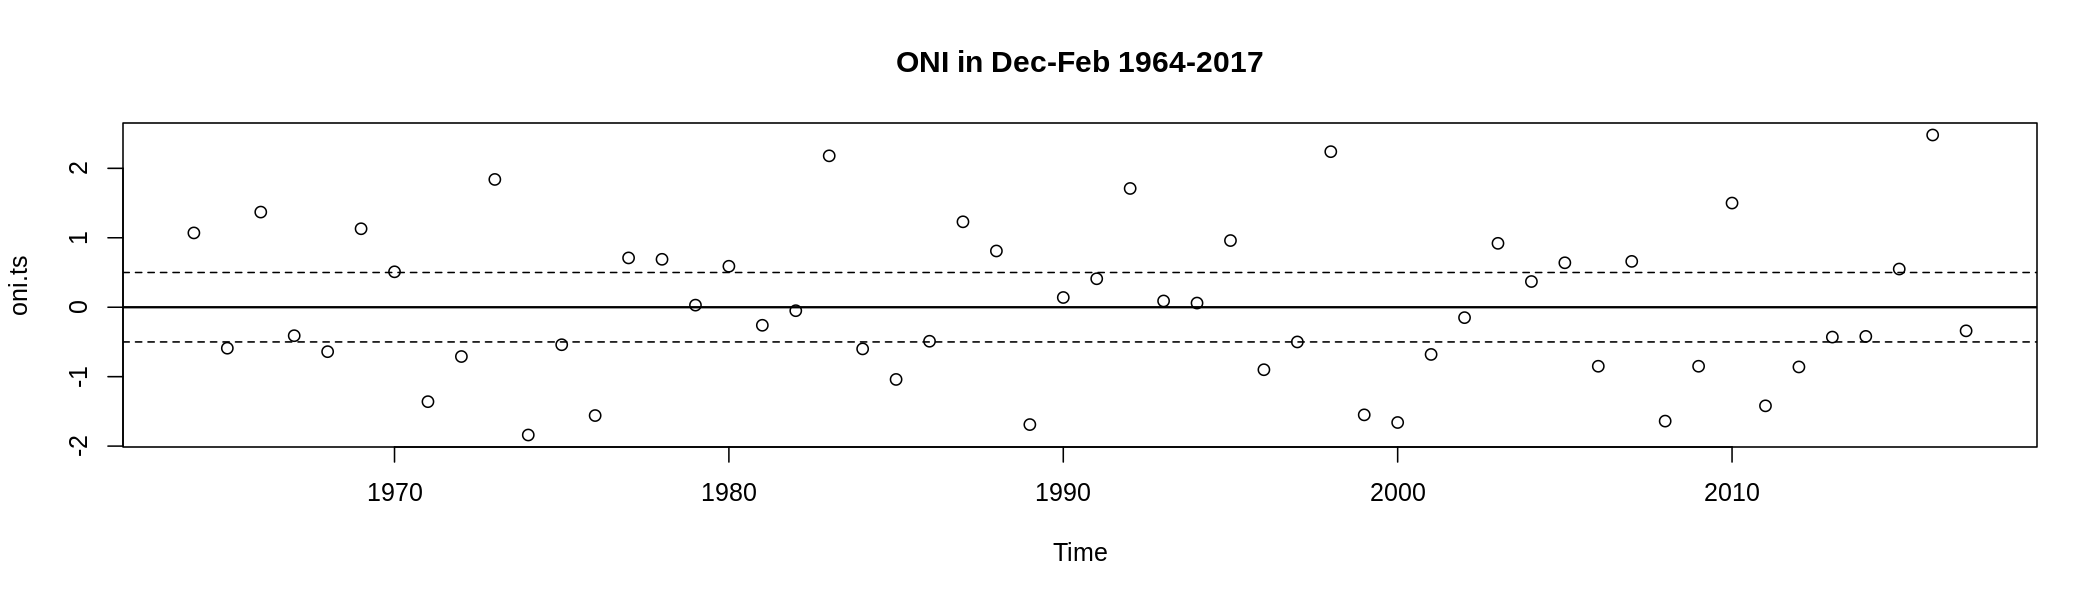

In [ ]:
DJF <- subset(oni.data, SEAS == 'DJF') # ONI
DJF <- subset(DJF, YR > 1963 & YR < 2018)

# Format plot
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)

# Create plot and populate with points
oni.ts <- ts(DJF$ANOM, start = 1964, frequency = 1)

## Test plot
plot(oni.ts, main='ONI in Dec-Feb 1964-2017', type = 'n')
points(oni.ts)

# Plot Constant Lines
abline(h = 0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)



### 2.1.2 MEI - Data
Below, I download the MEI dataset from [NOAA](https://psl.noaa.gov/enso/mei.old/table.html). 

In [ ]:
mei.url <- 'https://psl.noaa.gov/enso/mei.old/table.html'
mei.name <- tail(unlist(strsplit(mei.url, '/')),n=1)
mei.file <- paste('/tmp/', mei.name, sep = '')
download.file(mei.url, mei.file, method = 'auto')

In [ ]:
a <- readLines(mei.file)
for (my.line in a){
  a <- grep('^YEAR.*', my.line)
  if (length(a) > 0){
    print(my.line)
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

n.cols <- length(my.cols)

mei.df <- data.frame(matrix(ncol=n.cols, nrow=0))
colnames(mei.df) <- my.cols
str(mei.df)

a <- readLines(mei.file)
for (my.line in a){
  a <- grep('^[0-9].*', my.line)
  if (length(a) > 0){
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols){
      my.values <- c()
      for (d in my.data){
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,]=my.values
    }
  }
}

mei.df <- subset(mei.df, YEAR > 1963 & YEAR < 2018)
mei.deja.ts <- ts(mei.df$DECJAN, start = 1964, frequency = 1) # MEI


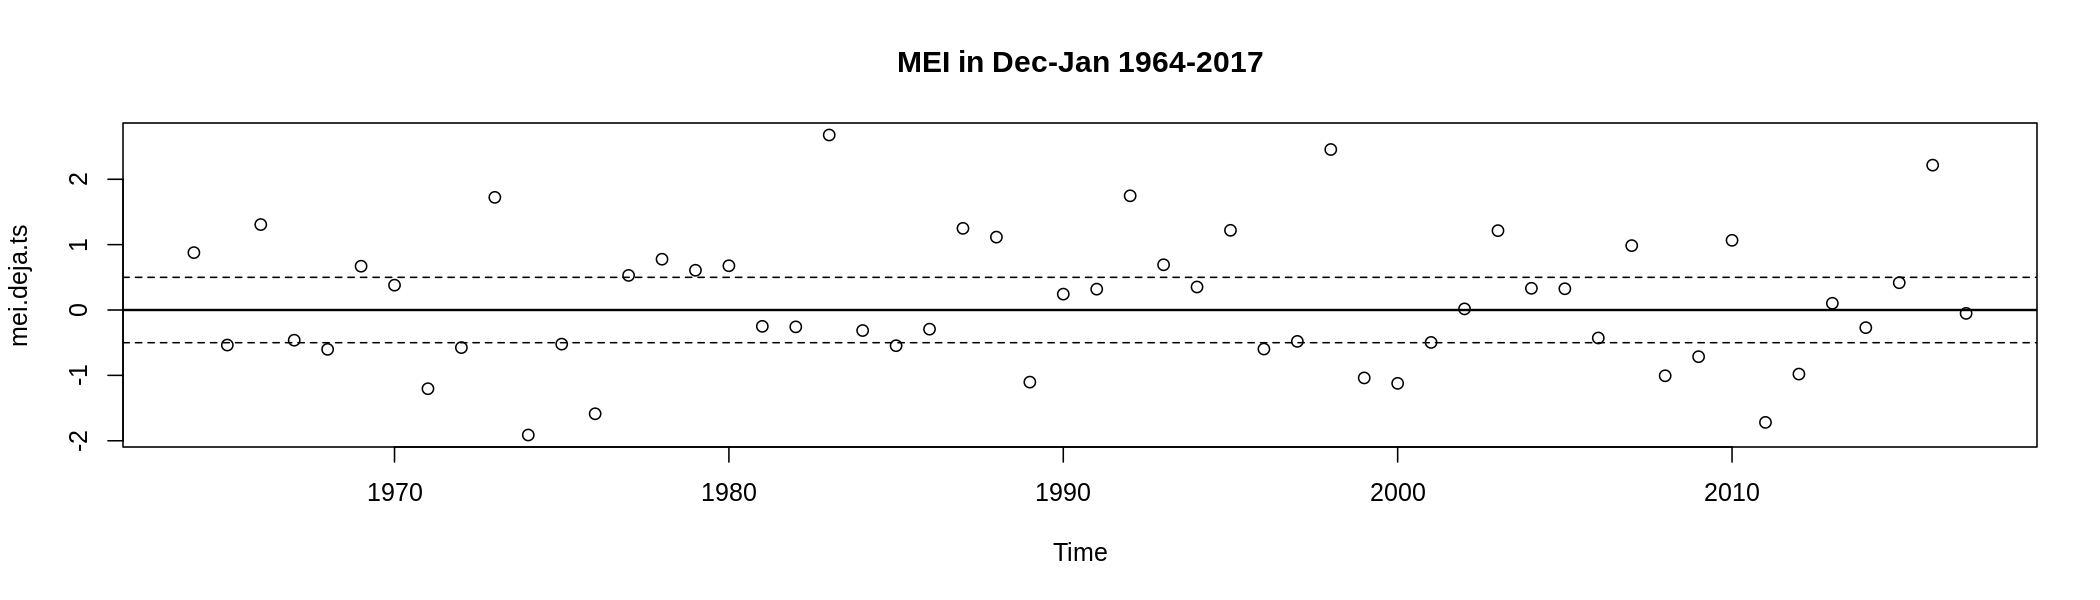

In [ ]:

options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)


## TEST PLOT
plot(mei.deja.ts, main = 'MEI in Dec-Jan 1964-2017', type = 'n')
points(mei.deja.ts, main = 'MEI in Dec-Jan 1964-2017')

# Plot Constant Lines
abline(h=0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

### 2.1.3 EMDAT - Data
Get EMDAT into a dataframe and reproduce the first figure. This data set was retrieved from this [website](https://public.emdat.be/).

In [ ]:
pad.file <- "./emdat_public.csv"
pad.df.all <- read.csv(pad.file, header=TRUE, skip=6)

In [ ]:
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Deaths", "Declaration", 
                   "OFDA.Response", "Total.Affected")
pad.df <- pad.df.all[cols.interest]

### 2.1.4 World Population Data
We need to work with some of the data before we can plot the PAD per 1000. One of the steps we need to take is downloading world population data so we can then calculate the PAD per 1000 correctly. This data is retrieved from the [World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL).

So, below each step is taken and explained in the comment next to it. 

In [2]:
# Download the zip of our table data
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)

In [3]:
unzip(zipfile = wbank.file, exdir = "/tmp")

In [4]:
# Find the CSV with country total populations from all the unzipped files.
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}
wb.file <- paste("/tmp/", my.file, sep="")
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)

[1] "API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv"


In [ ]:
# Loop through each row of our data frame and
# find the matching country and year
# remember that year columns in World Bank start with "X"
# and save the population to the original pad dataframe.
for (i in 1:nrow(pad.df)) {
  # Remember i is the row index in pad.df
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start.Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  # Match returns "NA" if no match
  a <- match(tmp.iso, wb.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- wb.df[,tmp.col][a]
    # We can create new dataframe columns on the fly
    pad.df[i, 'POP'] = tmp.pop
    #print(c(tmp.iso, tmp.year, tmp.pop))
  } else {
    # Make sure to assign missing values, too!
    pad.df[i, 'POP'] = NA
    print(paste("Could not match", tmp.iso))
  }
}

In [ ]:
# Find the total population of unique counties impacted by disasters for 1964
years <- sort(unique(pad.df$Start.Year))

pops <- list()
pads <- list()
for (j in 1:length(years)){
  # Calculate the total number of people impacted by disasters in year[j]
  # Filter out any NA rows/cols
  my.64.pad <- subset(pad.df, Start.Year == years[j])
  pad.64 <- 0
  for (i in 1:nrow(my.64.pad)){
    if (!is.na(my.64.pad$Total.Affected[i]) & !is.na(my.64.pad$POP[i])) {
      my.ta <- my.64.pad$Total.Affected[i]
      pad.64 <- pad.64 + my.ta
    }
  }
  pads[[j]] <- pad.64

  # Calculate (per 1000) PAD for year[j]
  pop.64 <- 0
  for (my.iso in unique(my.64.pad$ISO)){
    #print(my.iso)
    a <- match(my.iso, my.64.pad$ISO)
    tmp.pop <- my.64.pad$POP[a]
    if (!is.na(tmp.pop)) {
      pop.64 <- pop.64 + tmp.pop
    }
  }
  pops[[j]] = pop.64
  
}
pads <- unlist(pads, use.names=FALSE)
pops <- unlist(pops, use.names=FALSE)

# Calculate (per 1000) PAD for each year
pad.vals <- pads/pops*1000 

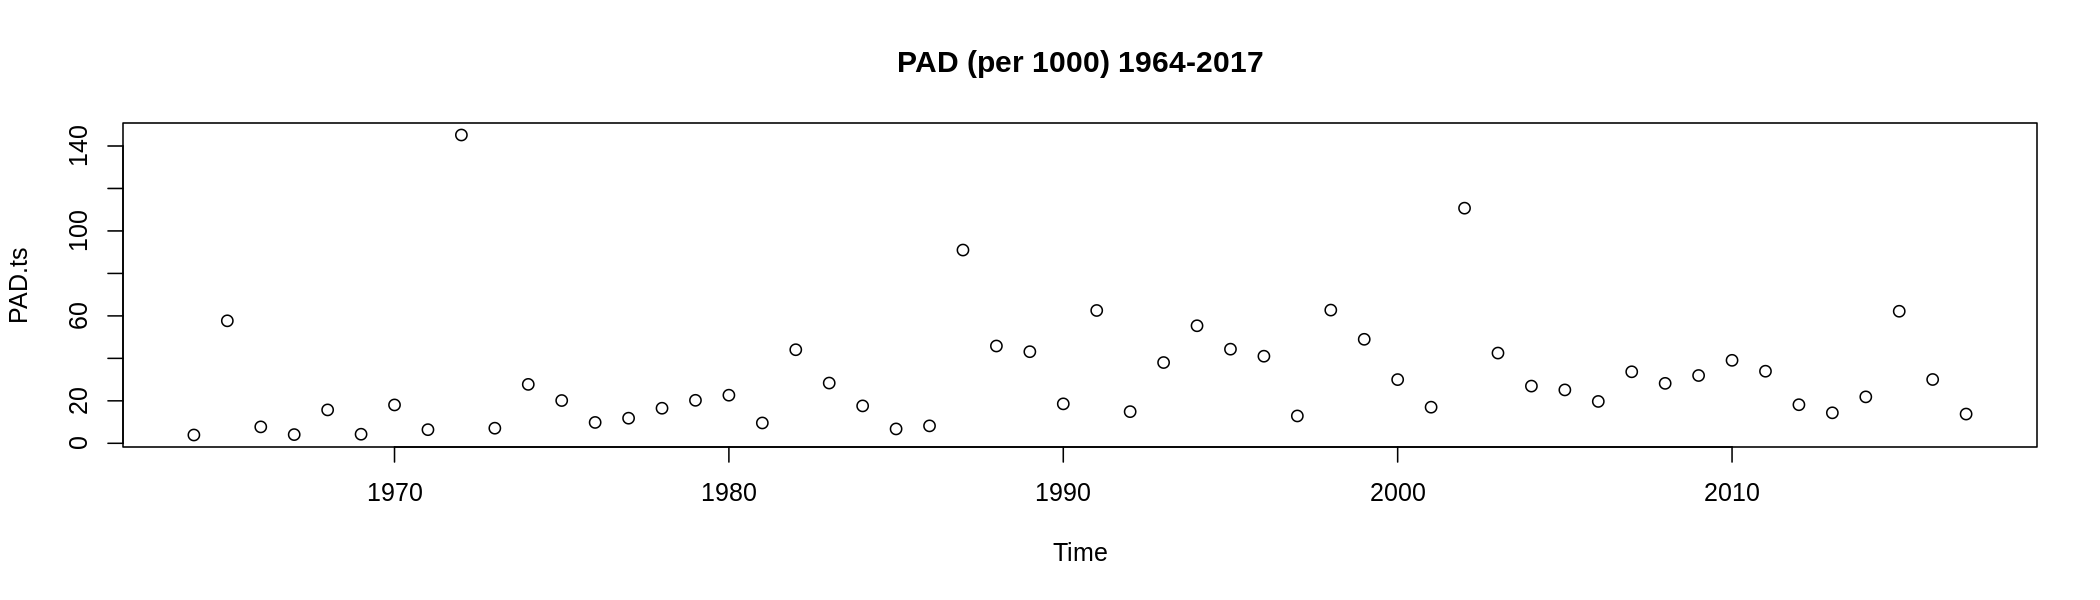

In [ ]:
PAD.ts <- ts(pad.vals, start = 1964, frequency = 1)

options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)

plot(PAD.ts, main = 'PAD (per 1000) 1964-2017', type = 'n')
points(PAD.ts, main = 'PAD (per 1000) 1964-2017')

### 2.1.5 Waves - Data

A further data set beyond those covered in the lab will be explored: wave height data. This dataset is from an [Ocean Buoy](https://www.ndbc.noaa.gov/station_page.php?station=46254) in the Pacific Ocean off of the Scripps Pier in San Diego, CA. The data set itself was retrieved from the UCSD webpage [here](https://cdip.ucsd.edu/themes/cdip?d2=p70&pb=1&u2=s:201:st:1:v:min_max_mean:t:data:dt:202102). It is aggregated by year-week from 2013 to 2021 (the full range of data set). The data set starts on the 12th week of 2013 and ends on the 9th week of 2021.

To retrieve this data, follow the steps below:

- navigate [here](https://cdip.ucsd.edu/themes/cdip?d2=p70&pb=1&u2=s:201:st:1:v:min_max_mean:t:data:dt:202102)
- select "month-year"
- copy + paste the tabular data into a .txt file
- copy + paste these column names to the first line in the file: (Year	Week	Mean.Hs	Mean.Tp	Mean.Ta	Mean.SST	Mean.cur.sp	Mean)
- save the file as "wavedata.txt" then import it into this colab notebook

While there are various columnar values, where plots explaining each one for a given day can be seen [here](https://cdip.ucsd.edu/themes/cdip?d2=p70&pb=1&u2=s:201:st:1:v:sea_swell:dt:202102), I only focused "Mean.Hs", which is the mean wave height in feet where mean is calculated on the given aggregation of time (week). More information about the parameters available can be read about [here](https://cdip.ucsd.edu/themes/cdip?d2=p70&pb=1&u2=s:201:st:1:v:product_descriptions&u3=p_desc:pm_format). 

In [ ]:
wave <- read.delim('wavedata.txt', header = TRUE, sep ='\t')

## 2.2 Data Analysis
Each dataset, once collected, is then analyzed using our toolkit of Realizations, Periodograms, Parzen Windows, and Autocorrelation Function plots. These tools are utilized to determine dominant frequencies and periods within the data, as well as term correlations.

### 2.2.1 ONI - Analysis

In [ ]:
install.packages('tswge') # install and import the book's library to help with plotting
library('tswge')

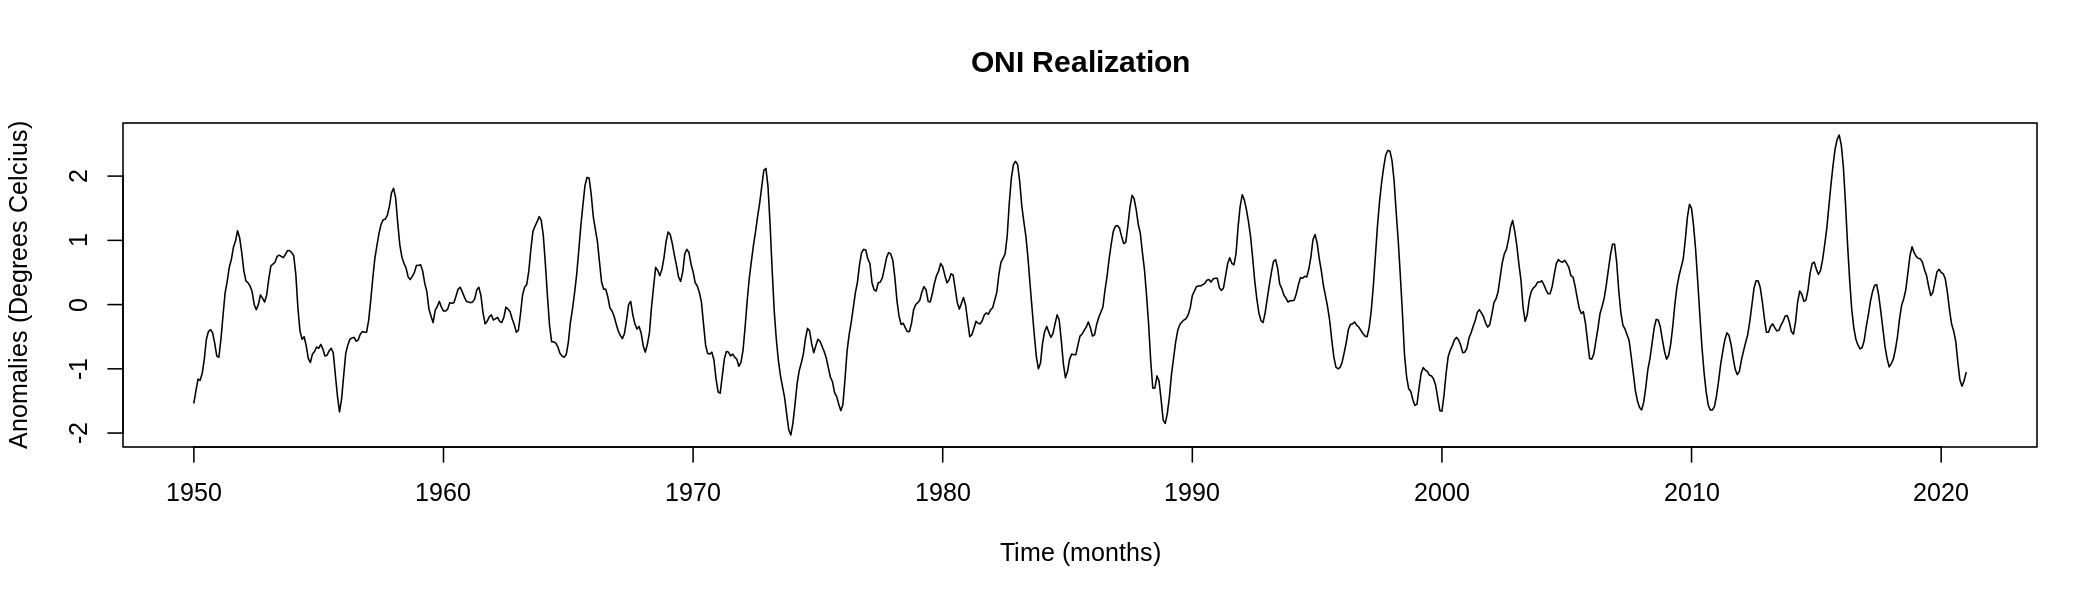

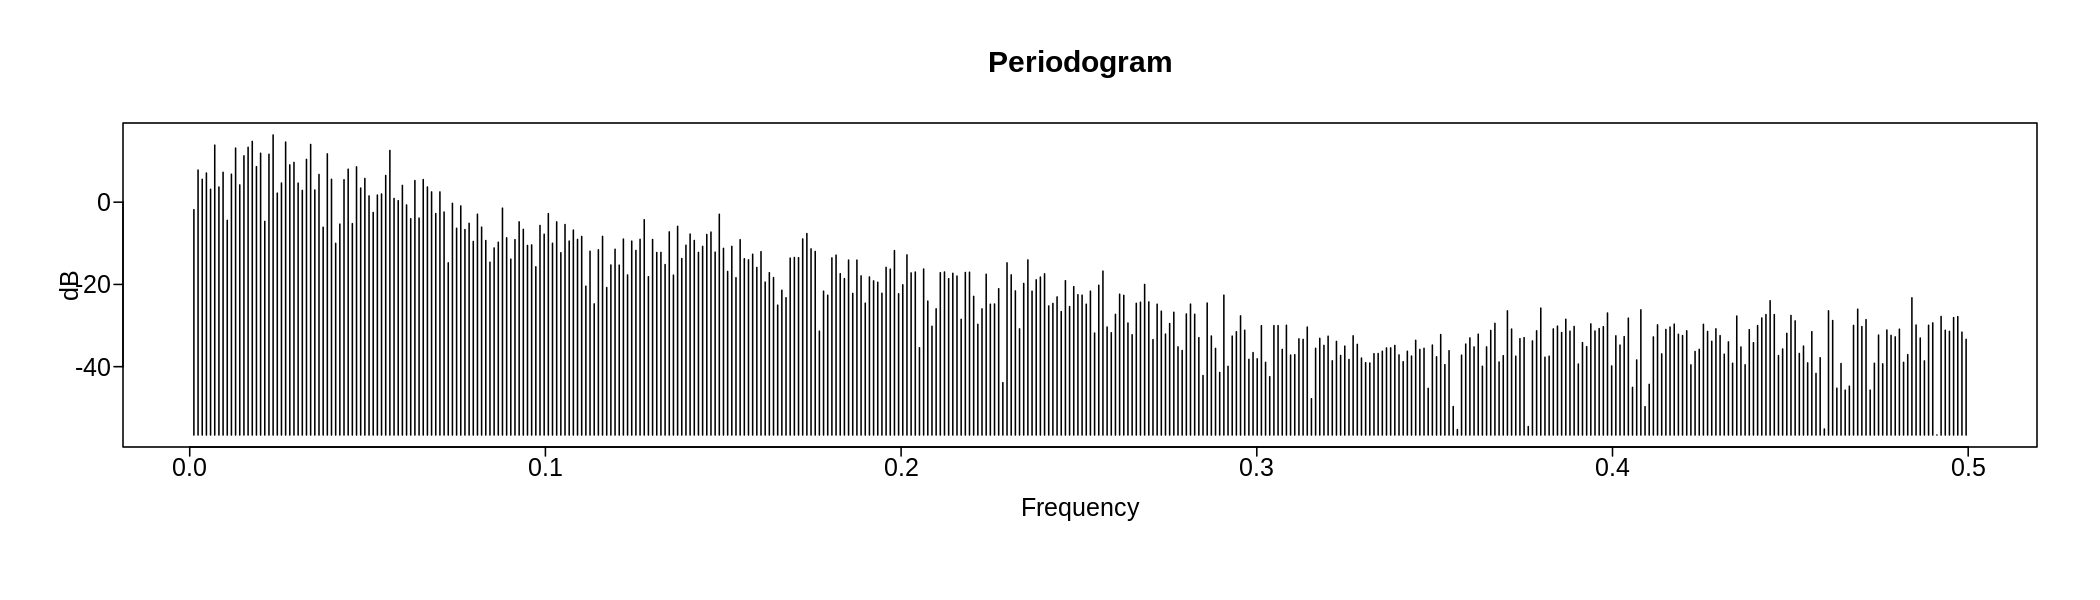

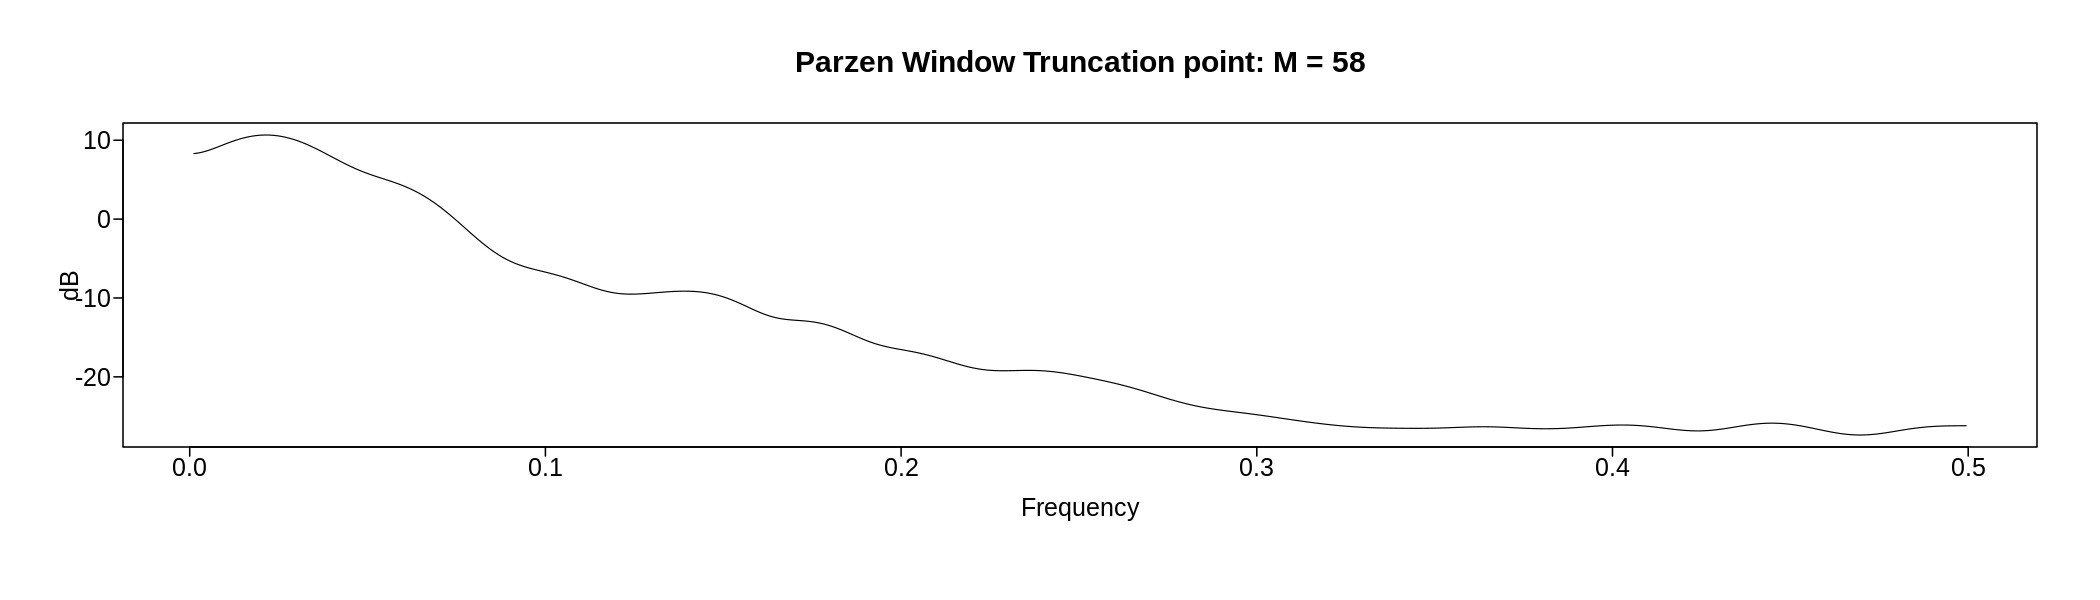

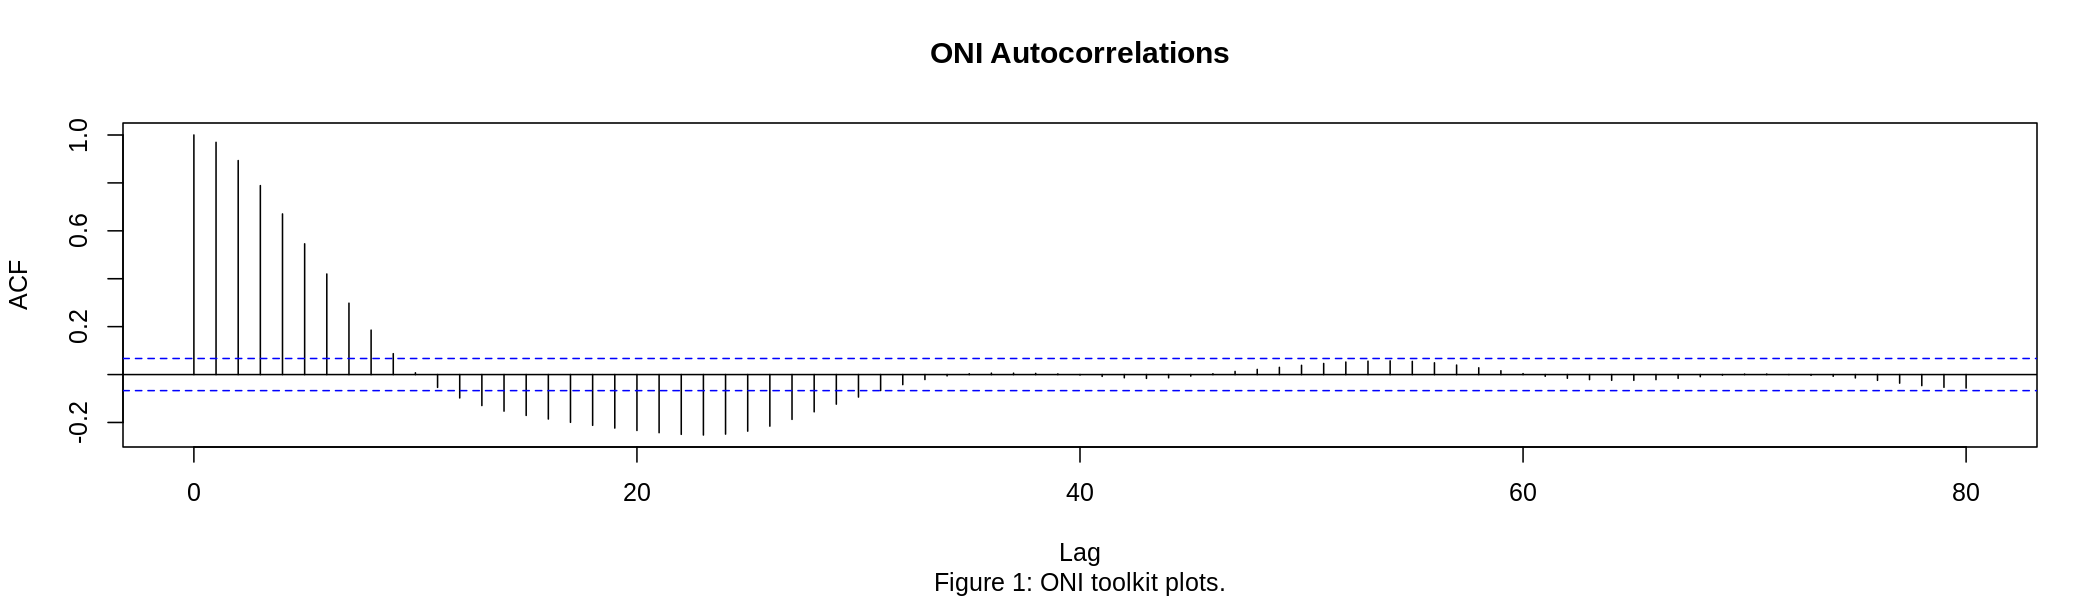

In [ ]:
temp <- ts(oni.data$ANOM, start = 1950, freq = 12)
plot(temp ,xlab = 'Time (months)'
    ,ylab = 'Anomalies (Degrees Celcius)'
    ,main='ONI Realization'
    ,type ='l'
    ,lty = 1)
oni.plot <- period.wge(oni.data$ANOM)
par.oni <- parzen.wge(oni.data$ANOM)

acf(oni.data$ANOM, main = 'ONI Autocorrelations', sub = 'Figure 1: ONI toolkit plots.',lag.max = 80)

<!-- It appears that in the ONI realization for anomalies, there is certainly some sort of periodic behavior occuring. Particularly, the periodic trend is visible at roughly 1973 and repeats about a decade later in 1983.  -->

In [ ]:
f1 <-  oni.plot$freq[which.max(oni.plot$pgram)]

cat('Frequency 1: ',f1, '\n')
cat('Period 1: ',1/f1, '\n')

Frequency 1:  0.02347418 
Period 1:  42.6 


<!-- We see that there appears to be a peak in the Parzen window near about 0.02. So, we can find the maximum value in the periodigram and use that index to identify a frequency of $$f= 0.02347$$ which we can translate into a period of $$p_1 = 42.607$$ So, we can confirm periodic behavior about every 42.607 months since the data set is aggregated as such. -->

### 2.2.2 MEI - Analysis

In [ ]:
install.packages('reshape')
library('reshape')

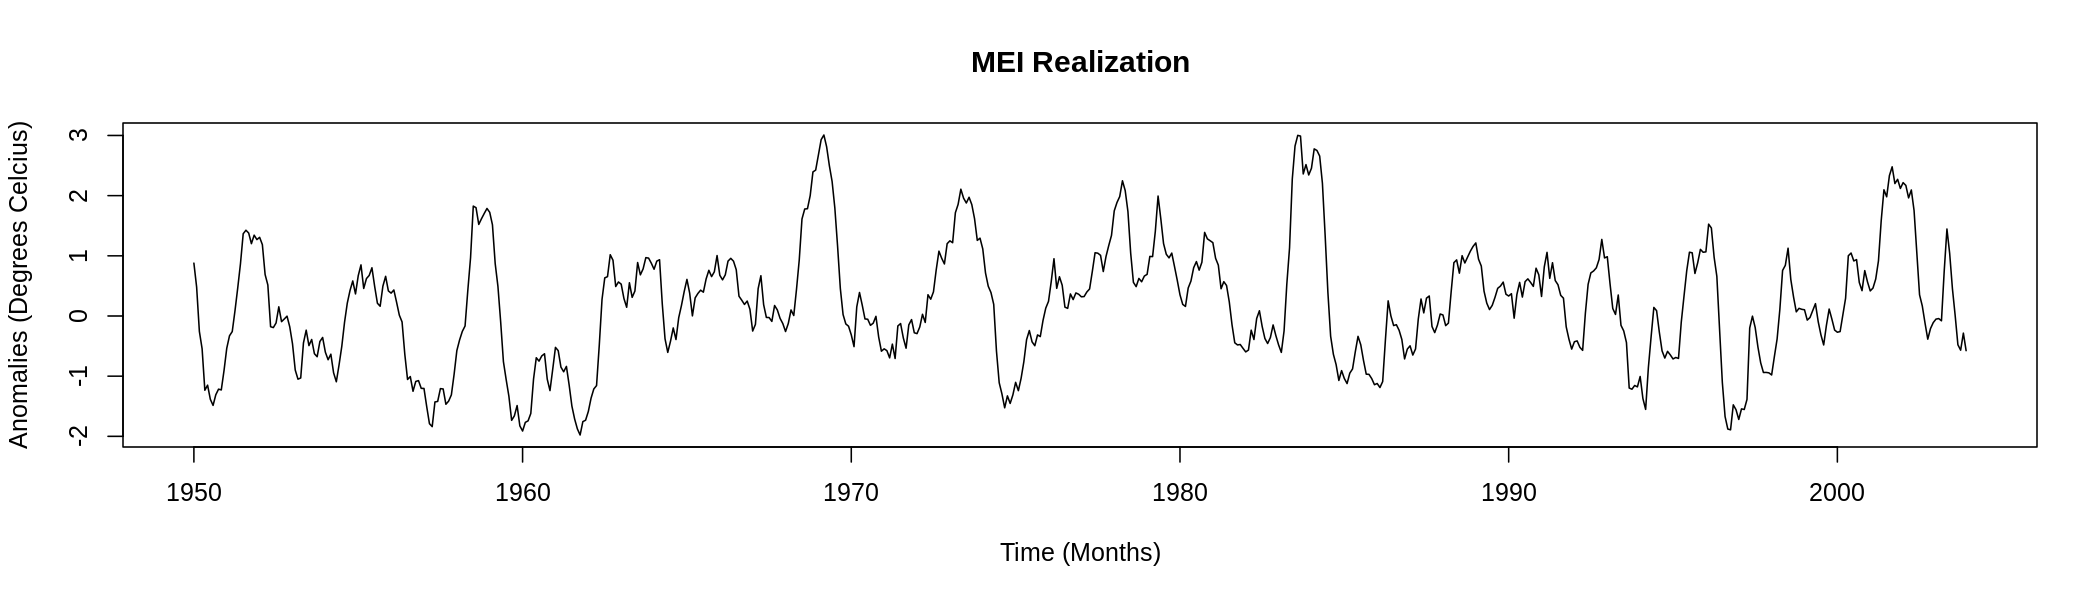

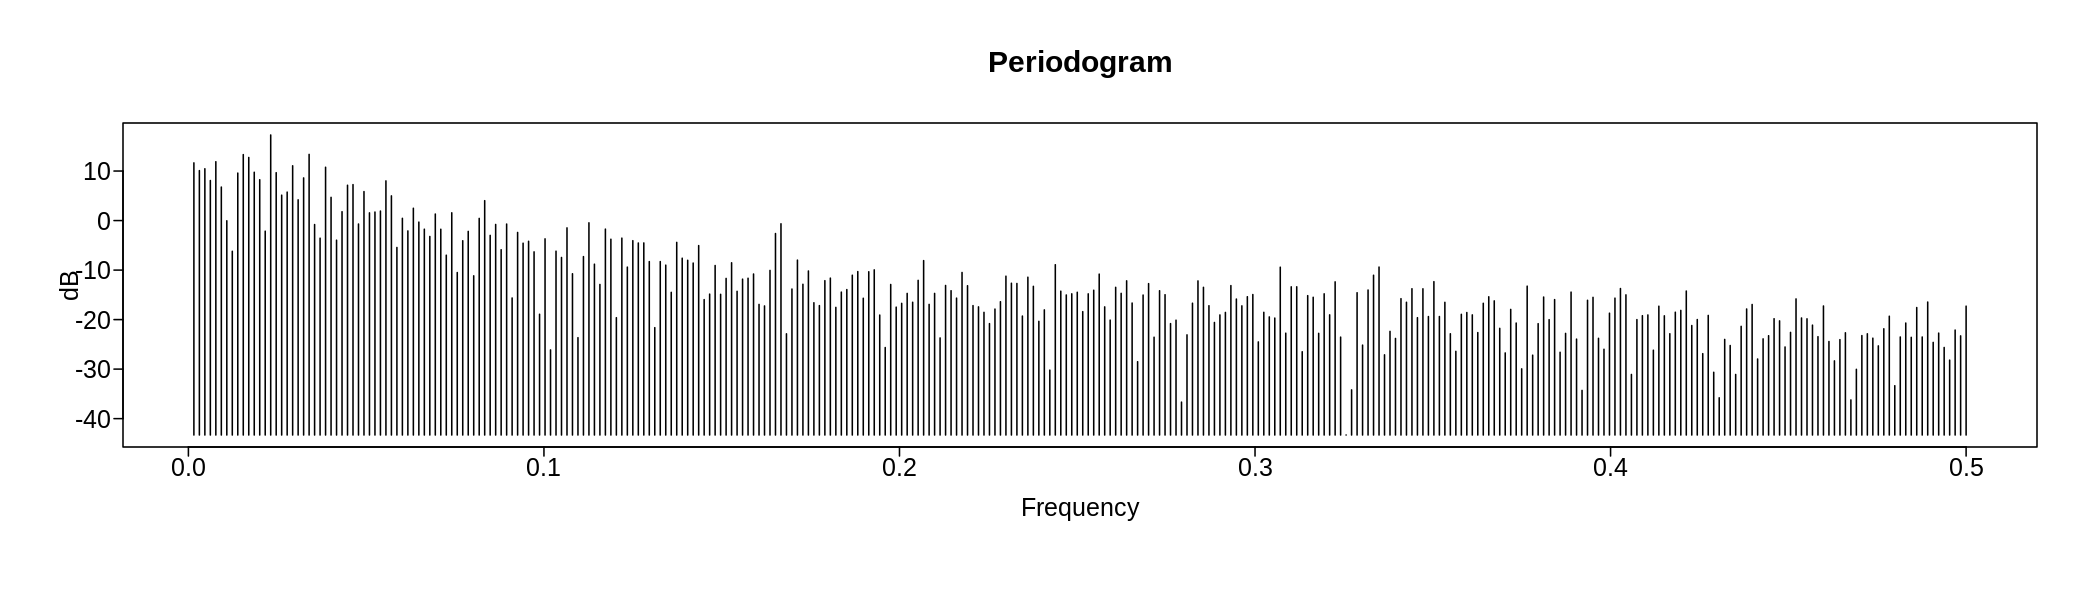

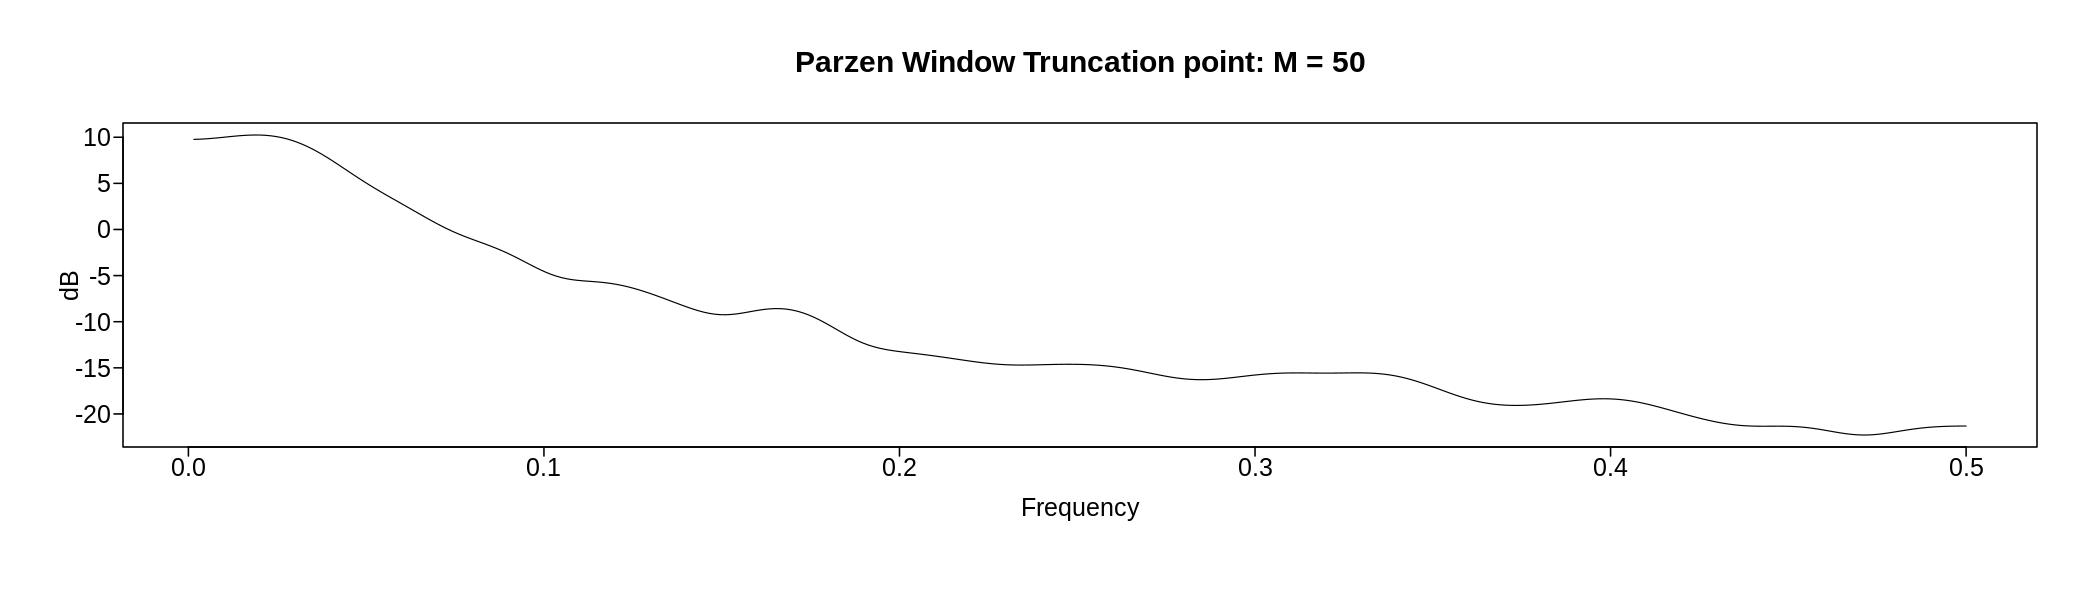

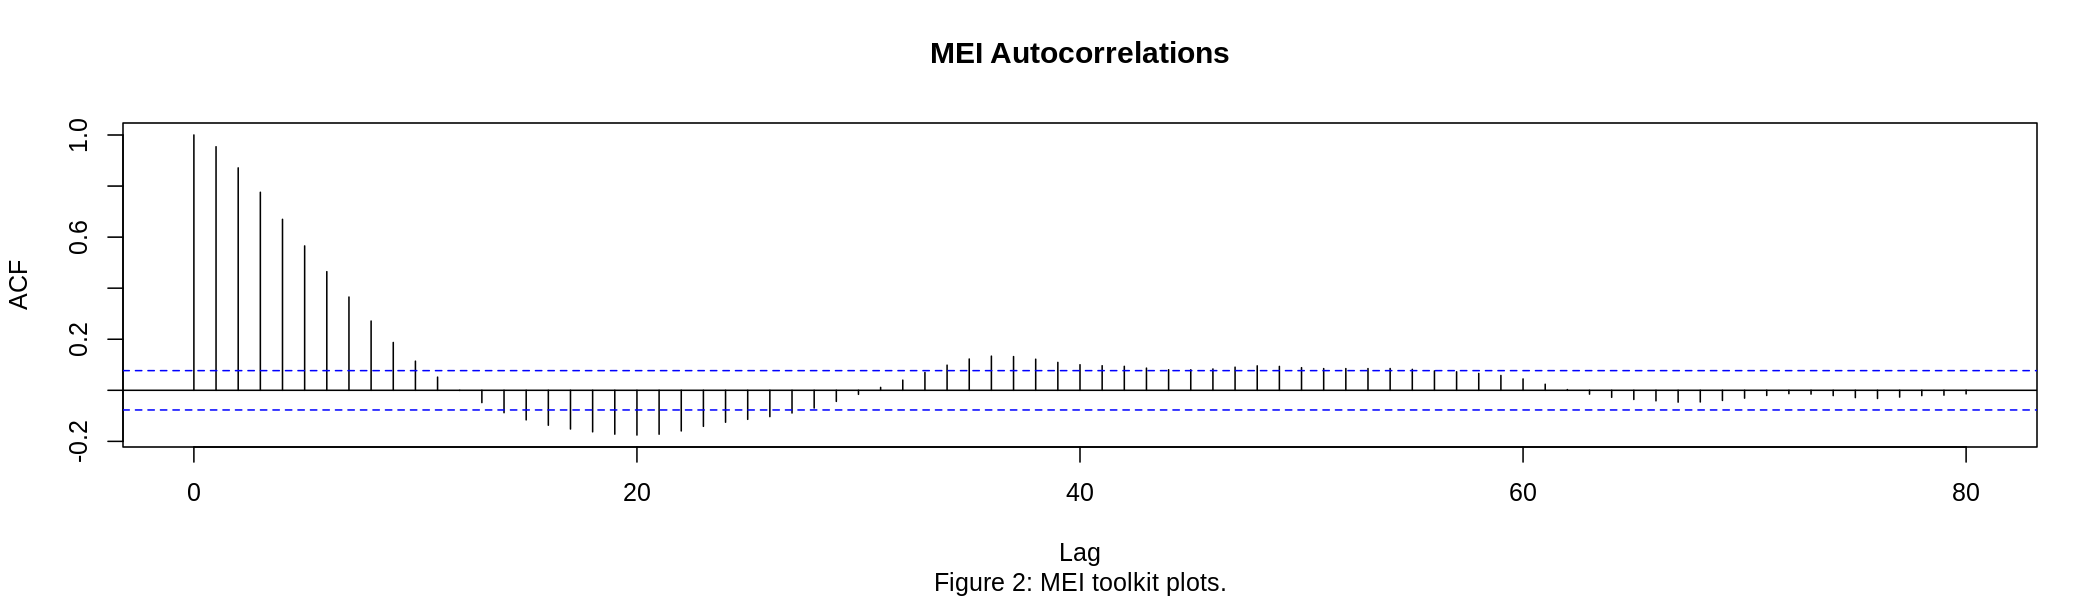

In [ ]:
mei.dat <- melt(mei.df, id = 'YEAR') # melt the data so we can get it closer to looking like months
mei.dat <- mei.dat[order(mei.dat[,1], mei.dat[,2]),] # sort the dataframe to get it into order

temp <- ts(mei.dat$value, start = 1950, freq = 12)
plot(temp ,xlab = 'Time (Months)'
    ,ylab = 'Anomalies (Degrees Celcius)'
    ,main='MEI Realization'
    ,type ='l'
    ,lty = 1)

mei.plot <- period.wge(mei.dat$value)
par.mei <- parzen.wge(mei.dat$value)

acf(mei.dat$value, main = 'MEI Autocorrelations', sub = 'Figure 2: MEI toolkit plots.',lag.max = 80)

<!-- There certainly again appears to be some sort of periodic trend in the realization of MEI data. In fact, the trend of the realization looks very similar to the ONI data set. Thus, we could expect to see a similar period from our data set. -->

In [ ]:

f1 <- mei.plot$freq[which.max(mei.plot$pgram)]
f2 <- mei.plot$freq[which.max(mei.plot$pgram[c(560:length(mei.plot$pgram))])] # this is the second frequency close to 0.2

cat('Frequency 1: ', f1, '\n')
cat('Period 1: ', 1/f1, '\n')
cat('Frequency 2: ', f2, '\n')
cat('Period 2: ', 1/f2, '\n')


Frequency 1:  0.02328431 
Period 1:  42.94737 
Frequency 2:  0.1875 
Period 2:  5.333333 


<!-- The Parzen window seems to show us two peaks in the frequency. One close to 0.02, and another close to 0.18. Thus, we find the both of these frequency spikes and see $$f_1 = 0.02328 \\ f_2 = 0.1875$$ giving us then periods of $$p_1 = 42.955 \\ p_2 = 5.3333$$ This makes sense when re-examining the realization above, as we see spikes over a longer timeframe consistent with the first period being about 43 months, $p_1 = 42.947$, or about 3.6 years. Between these larger spikes, we see smaller oscillations at about every half of a year, or $p_2 = 5.333$ months.  -->

### 2.2.3 PAD - Analysis

We calculate the PAD in accordance with the paper's definition of the statistic. This is defined to be the Total Number of People Affected by a disaster divided by the Total Population of the affected country, then multipled by 1000 (Lam et al., 2019).

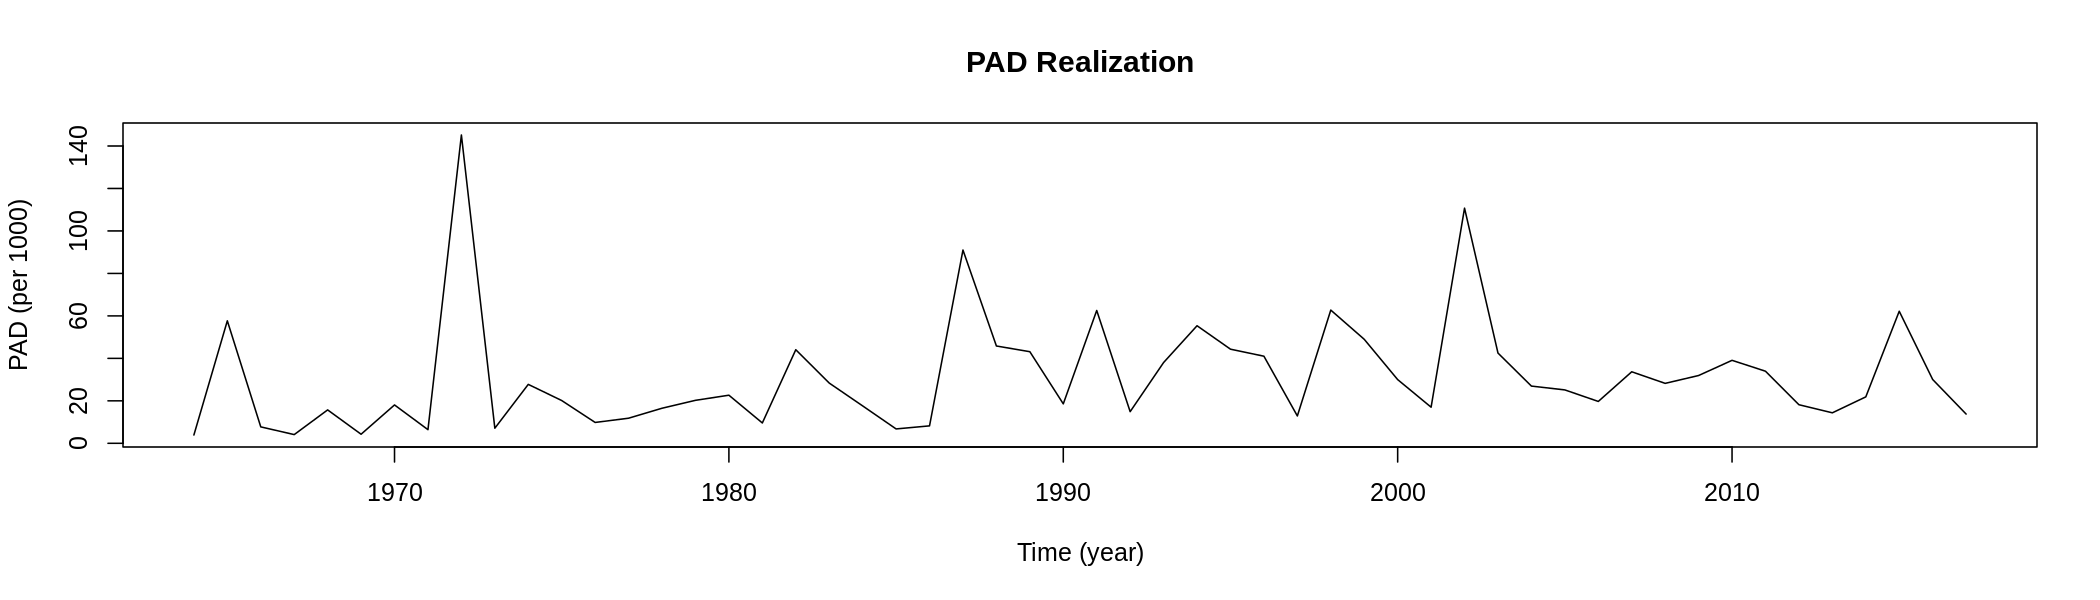

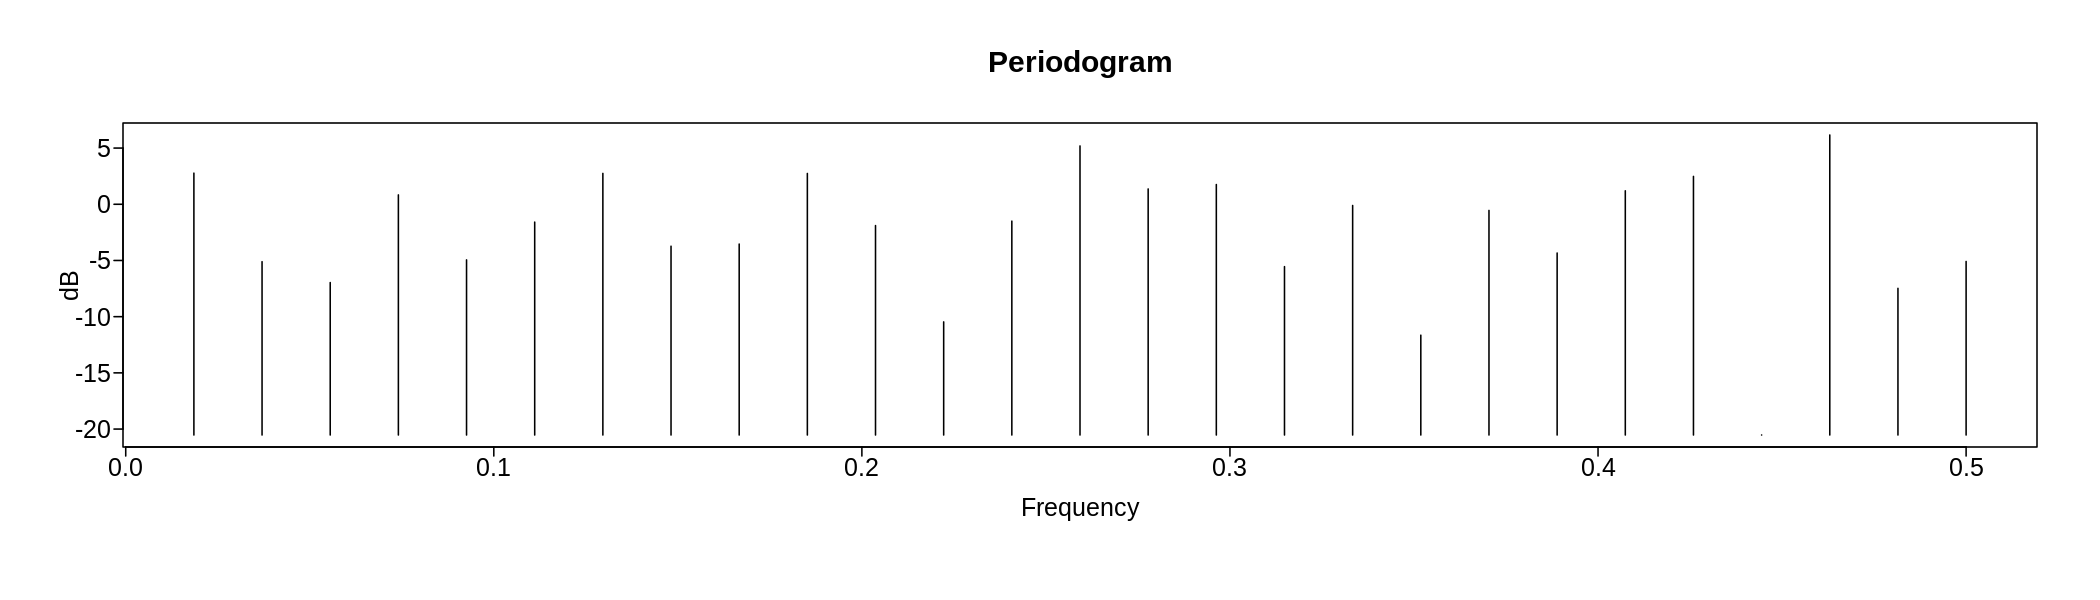

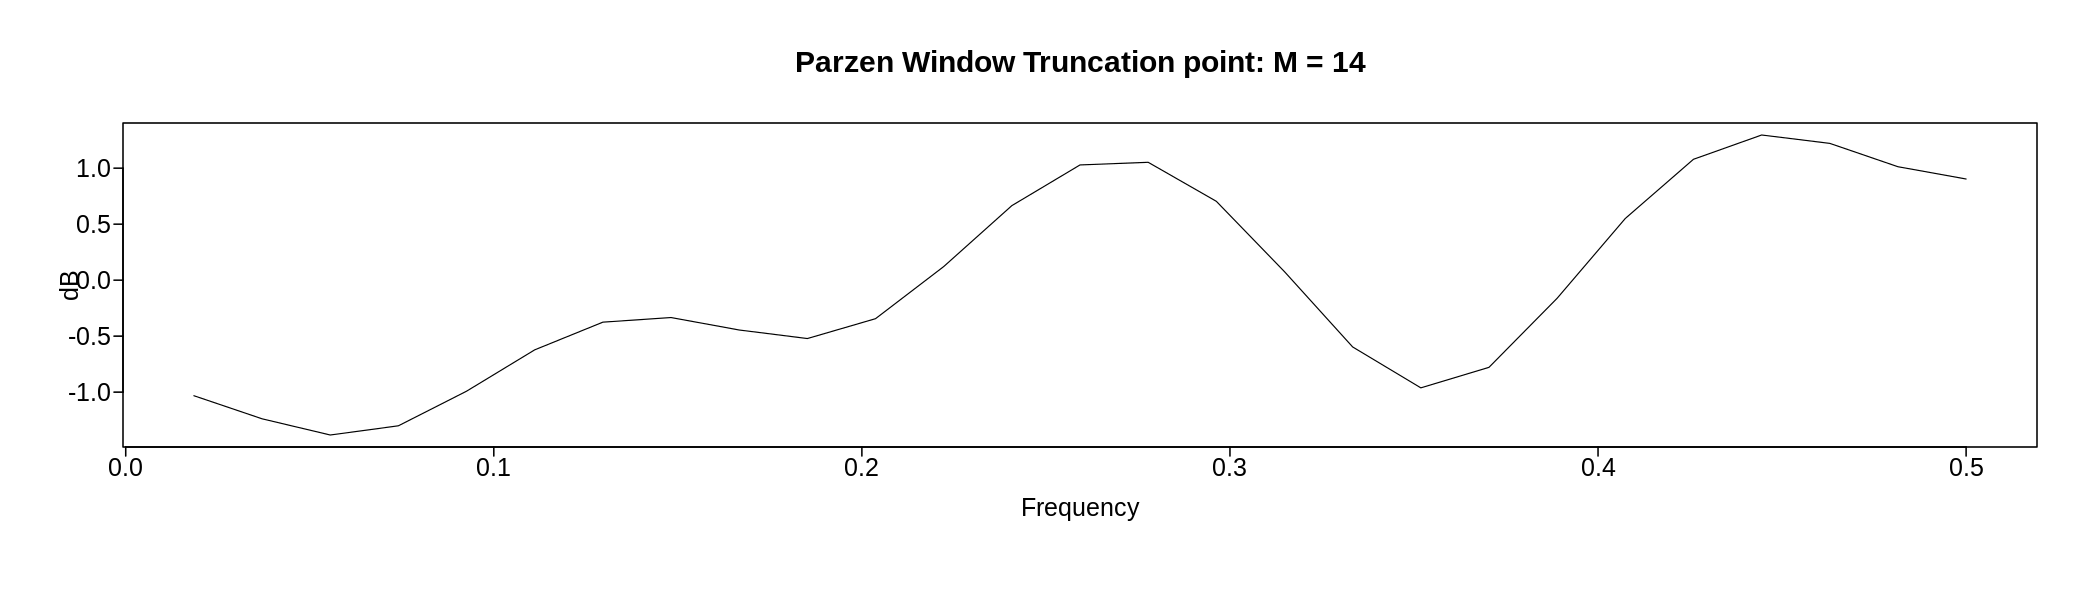

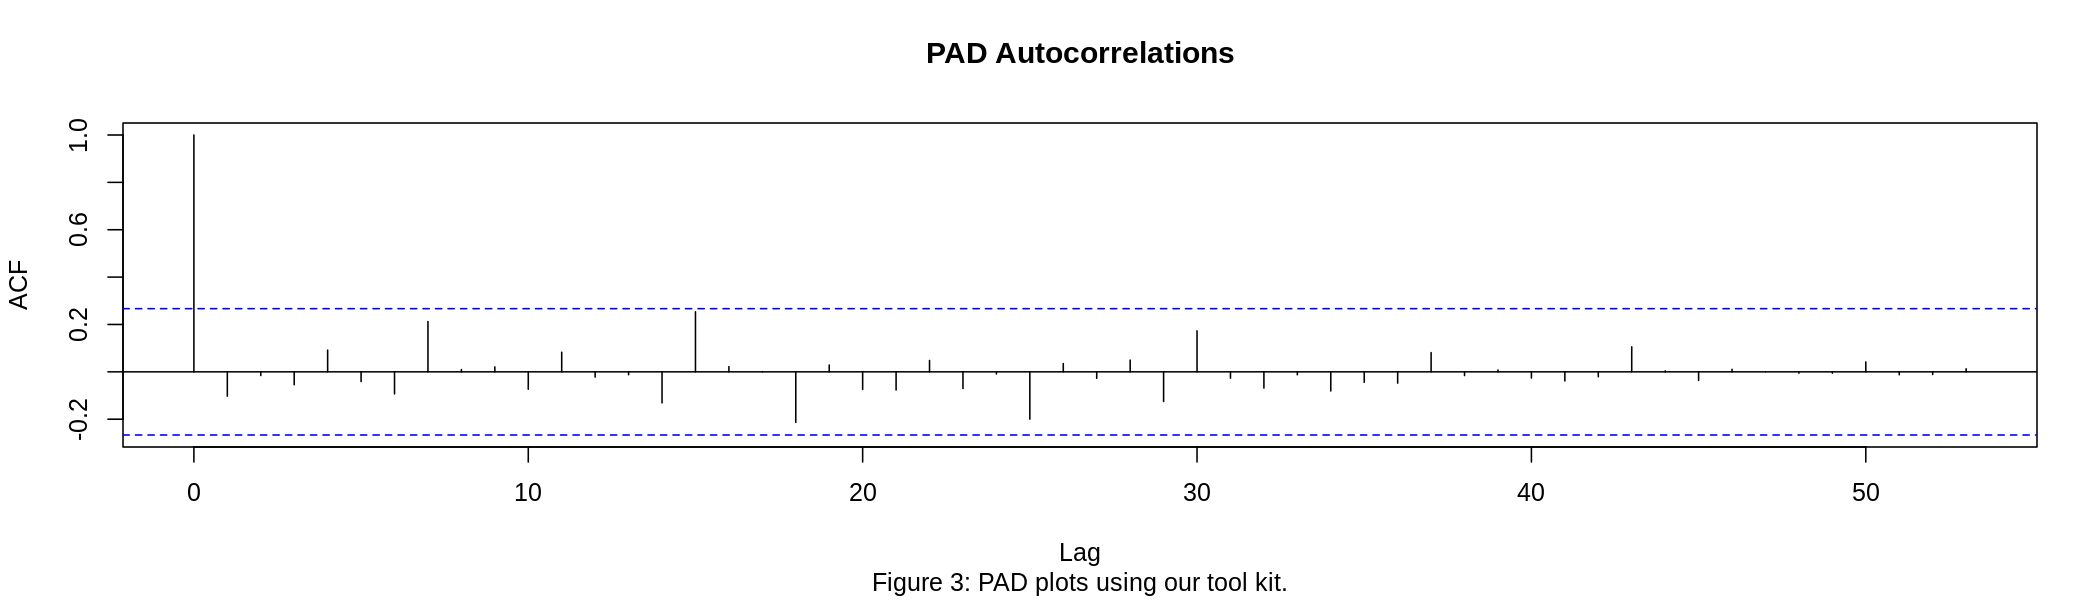

In [ ]:
#PAD , PAD.ts
plot(PAD.ts ,xlab = 'Time (year)'
    ,ylab = 'PAD (per 1000)'
    ,main='PAD Realization'
    ,type ='l'
    ,lty = 1)
pad.plot <- period.wge(PAD.ts)
par.pad <- parzen.wge(PAD.ts)

acf(PAD.ts, main = 'PAD Autocorrelations', sub = 'Figure 3: PAD plots using our tool kit.', lag.max = 80)

In [ ]:
f1 <- pad.plot$freq[which.max(pad.plot$pgram)] # First Peak

freqs <- pad.plot$freq[pad.plot$freq > 0.2 & pad.plot$freq < 0.3]
pgram <- pad.plot$pgram[pad.plot$freq > 0.2 & pad.plot$freq < 0.3]
f2 <- freqs[which.max(pgram)] # Second Peak

freqs <- pad.plot$freq[pad.plot$freq > 0.1 & pad.plot$freq < 0.2]
pgram <- pad.plot$pgram[pad.plot$freq > 0.1 & pad.plot$freq < 0.2]
f3 <- freqs[which.max(pgram)] # Third Peak 
cat('Frequency 1: ', f1,'\n') 
cat('Period 1: ', 1/f1,'\n')

cat('Frequency 2: ', f2,'\n') 
cat('Period 2: ', 1/f2,'\n')

cat('Frequency 3: ', f3,'\n') 
cat('Period 3: ', 1/f3,'\n')

Frequency 1:  0.462963 
Period 1:  2.16 
Frequency 2:  0.2592593 
Period 2:  3.857143 
Frequency 3:  0.1296296 
Period 3:  7.714286 


<!-- From the above plots, we find the three dominant frequencies to be: $$ f_1 = 0.4630 \\ f_2=0.2593 \\ f_3 = 0.1296$$
while these frequencies then translate into periods of:
$$ p_1 = 2.16 \\ p_2 = 3.8571 \\ p_3 = 7.7143 $$

Looking at the realization, $p_1$ makes sense as we see these peaks at much longer time steps, while at smaller time steps we see peaks that are fractional at $p_2$ and $p_3$ when compared to $p_1$. -->

### 2.2.4 Waves - Analysis

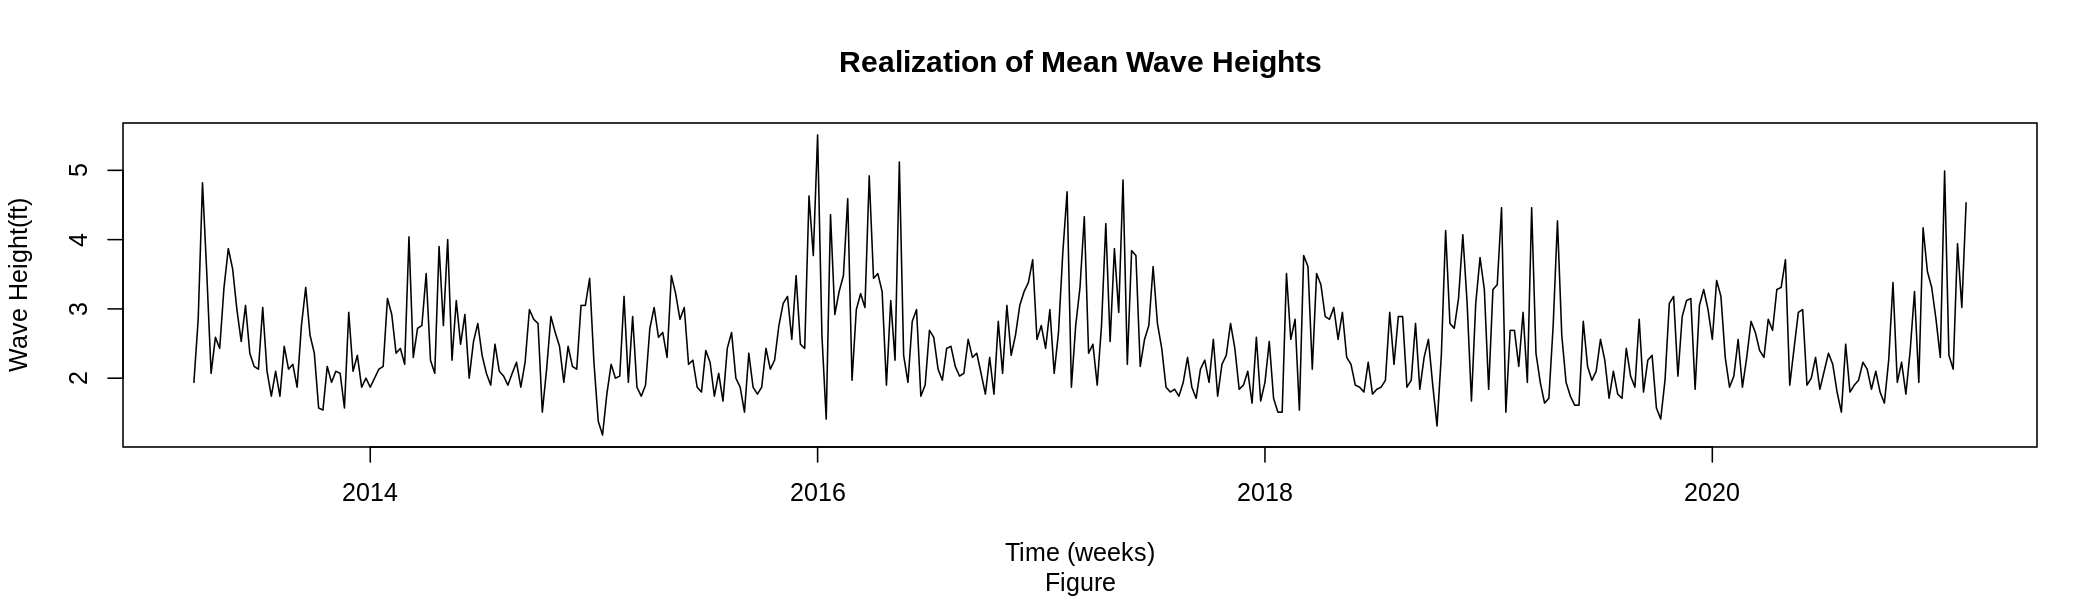

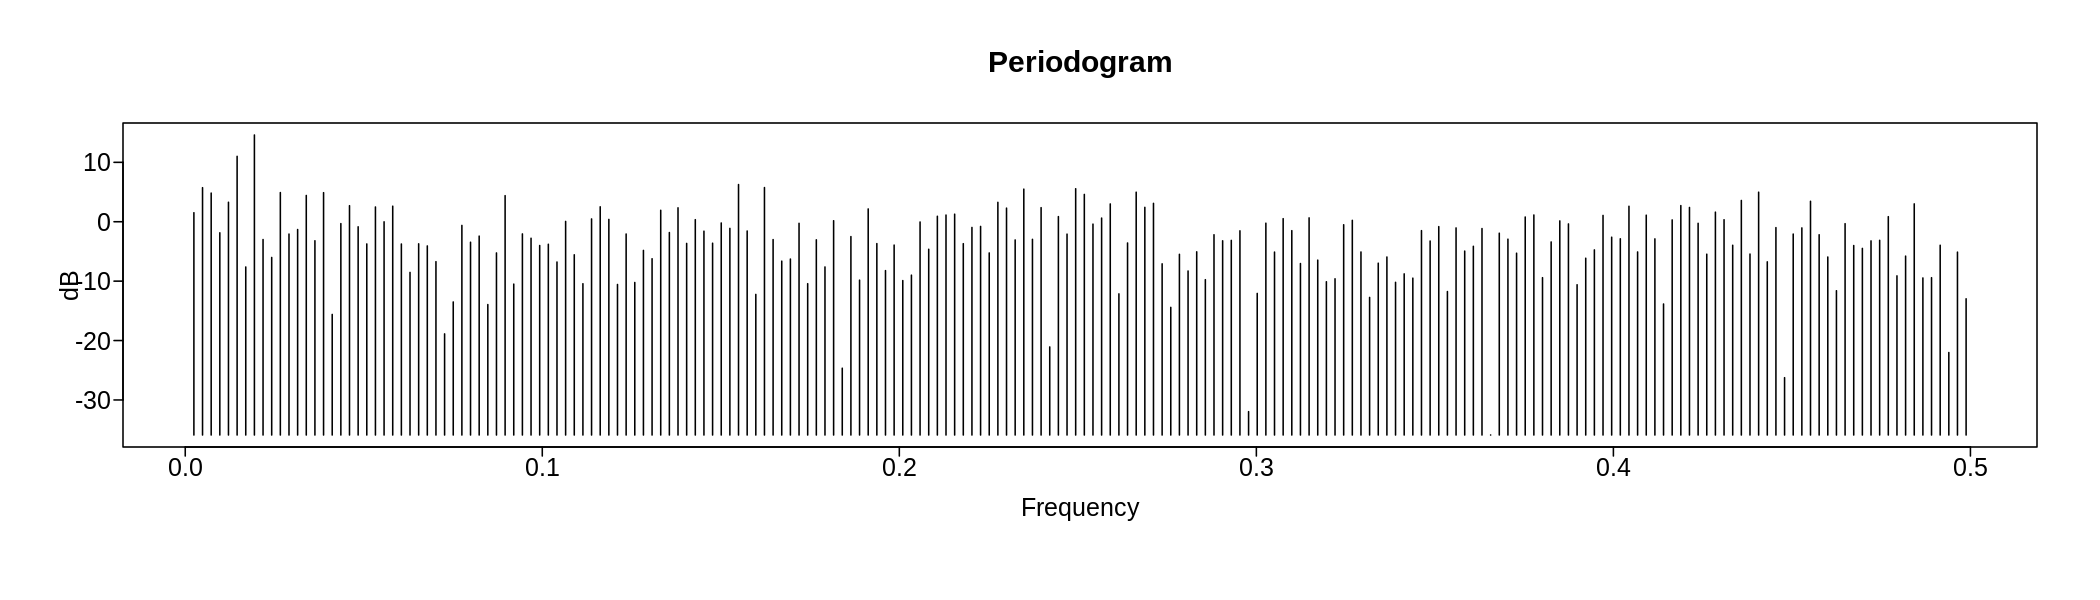

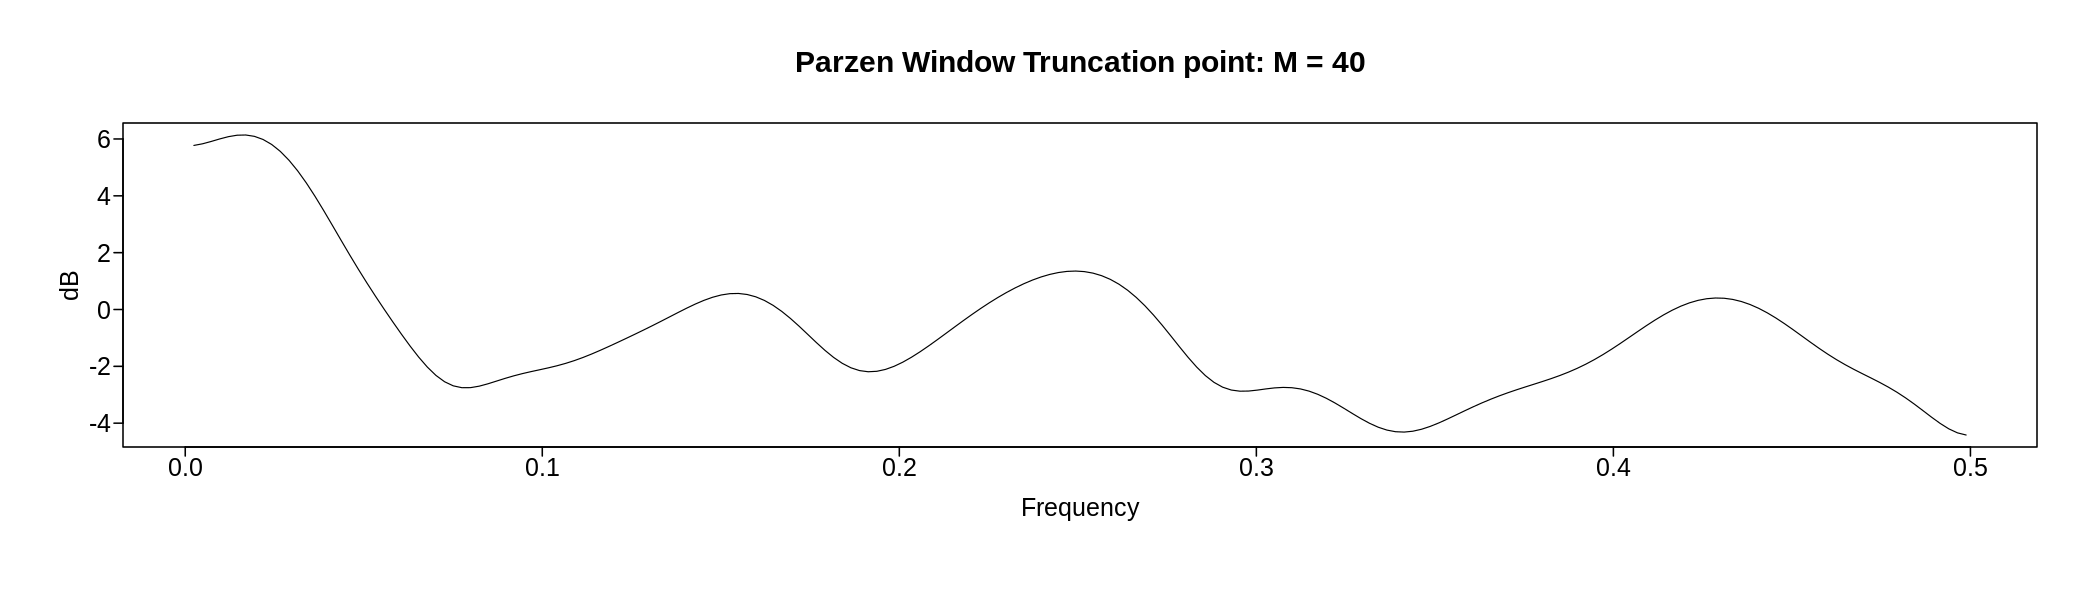

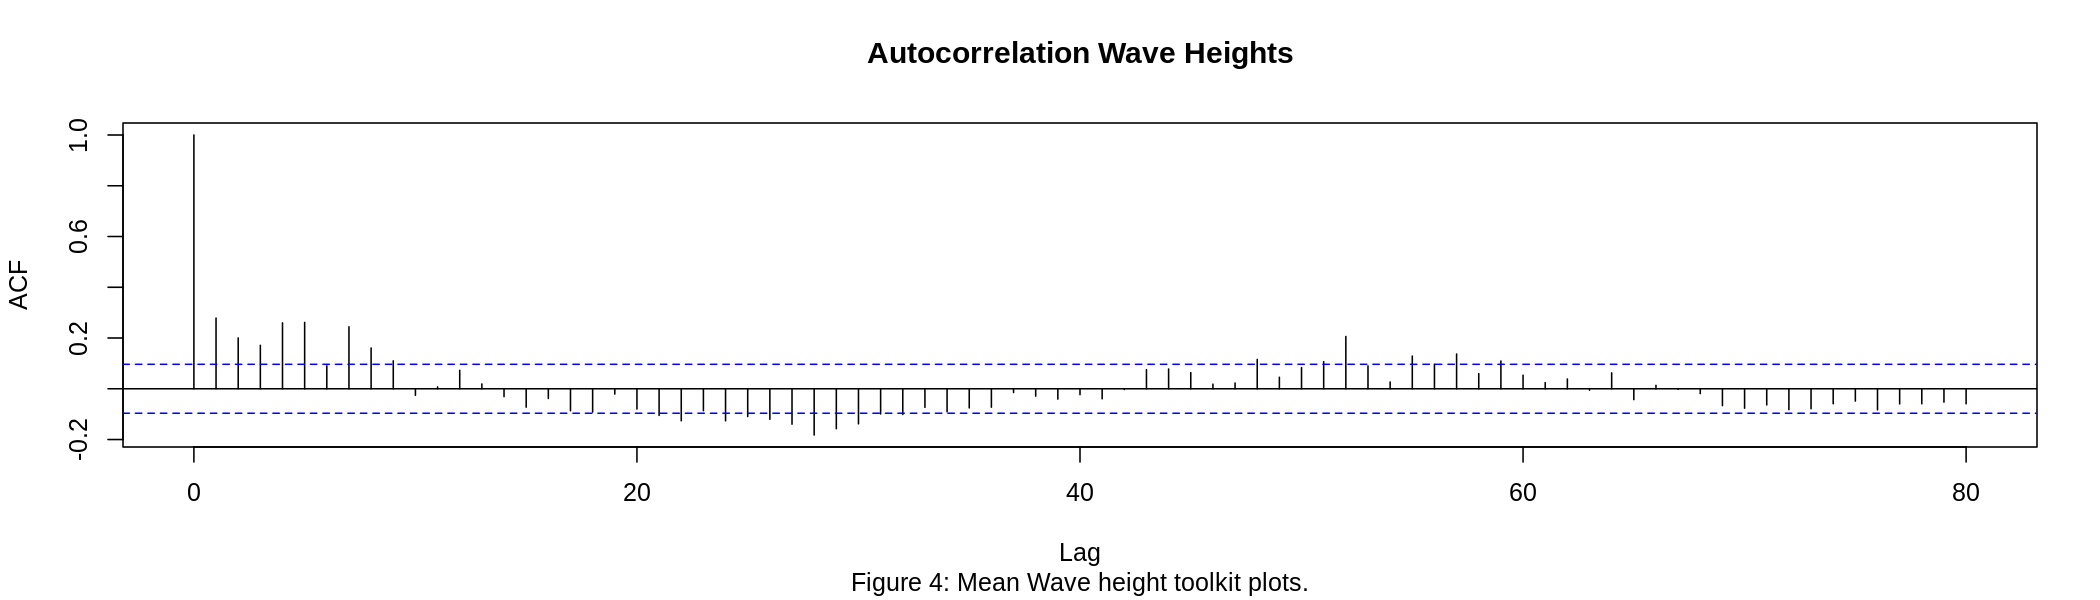

In [ ]:
wave.ts <- ts(wave$Mean.Hs, start = c(2013,12), frequency = 52)
plot(wave.ts, main = 'Realization of Mean Wave Heights', sub = 'Figure', xlab = 'Time (weeks)', ylab = 'Wave Height(ft)')
wave.plot <- period.wge(wave.ts)
par.wave <- parzen.wge(wave.ts)
acf(wave$Mean.Hs, lag.max = 80, main = 'Autocorrelation Wave Heights', sub = 'Figure 4: Mean Wave height toolkit plots.')

<!-- Having some experience with the domain of wave height data, it is not suprising that we see what appears to temporal oscillations each year with peaks in the winter months and troughs in the summer months. We can explore this period further in the plots below.

When looking at the autocorrelation plot, we can see that there is not alot of strong correlation beyond lag=0, but the yearly periodic trend identified below is very visible. 

Further, $ -0.2 < y < 0.2$ for a majority of $x$ values, with few peaks along the x-axis peaking yet still falling below $y = 0.4$. 

Thus, there does not appear to be much strong autocorrelation. This would be unusual when looking at the periodic trends from the plots above.  -->


In [ ]:
f1 <- wave.plot$freq[which.max(wave.plot$pgram)]
cat('Frequency 1: ', f1, '\n')
cat('Period 1: ', 1/f1, '\n')

pgram <- wave.plot$pgram[which(wave.plot$freq > 0.1 & wave.plot$freq < 0.2)]
freq <- wave.plot$freq[which(wave.plot$freq > 0.1 & wave.plot$freq < 0.2)]
f2 <- freq[which.max(pgram)]

cat('Frequency 2: ', f2, '\n')
cat('Period 2: ', 1/f2, '\n')

pgram <- wave.plot$pgram[which(wave.plot$freq > 0.2 & wave.plot$freq < 0.3)]
freq <- wave.plot$freq[which(wave.plot$freq > 0.2 & wave.plot$freq < 0.3)]
f3 <- freq[which.max(pgram)]

cat('Frequency 3: ', f3, '\n')
cat('Period 3: ', 1/f3, '\n')

pgram <- wave.plot$pgram[which(wave.plot$freq > 0.4 & wave.plot$freq < 0.5)]
freq <- wave.plot$freq[which(wave.plot$freq > 0.4 & wave.plot$freq < 0.5)]
f4 <- freq[which.max(pgram)]

cat('Frequency 4: ', f4, '\n')
cat('Period 4: ', 1/f4, '\n')

Frequency 1:  0.01937046 
Period 1:  51.625 
Frequency 2:  0.1549637 
Period 2:  6.453125 
Frequency 3:  0.2493947 
Period 3:  4.009709 
Frequency 4:  0.440678 
Period 4:  2.269231 


<!-- The dominant frequency is found to be at $$f_1 = 0.01937 \\ f_2 = 0.15496 \\ f_3 = 0.24939 \\ f_4 = 0.44068$$ So then we see a period of $$p_1 = 51.6250 \\ p_2 = 6.4531 \\ p_3 = 4.0097 \\ p_4 = 2.2692$$

This makes sense, as we see oscillations in the realization every year (52 weeks) or so. 

This temporal trend repeated each winter makes sense, as the winter months for this buoy encounter ocean swells coming from the North/North-West direction. These N/NW swells carry much greater wave heights with them along side much colder water. To the contrary, the summer months generally bring South/South-West swells, which bring the converse; smaller wave heights and warmer water.

As for the respective shorter periods, those can be easily seen in the realization above with the oscillations with peaks between the January and December months of each year. -->

### 2.2.5 El Nino Years - Analysis

We can find the El Nino years below by following the definition from the paper, which uses the NOAA definition of 5 consecutive months of ONI values greater than 0.5 degrees celcius, while La Nina events are 5 consecutive months less than -0.5 degrees celcius (Becker, 2015).

In [ ]:
## Identify El Nino Events (ONI > 0.5 for 5 consecutive timesteps)

oni.data$thresh <- oni.data$ANOM > 0.5          # Identify when ONI val indicates el nino event
oni.data$consec <- sequence(rle(as.character(oni.data$thresh))$lengths) # Sequence data for true when event recorded

years <- oni.data$YR[which(oni.data$thresh == TRUE & oni.data$consec == 5)] # record dates when el nino encountered
years <- years[which(years > 1963 & years < 2018)] # get only relevant study years

relevant.times <- oni.data[which(oni.data$thresh == TRUE),]
relevant.times <- relevant.times[which(relevant.times$YR > 1963 & relevant.times$YR < 2018),]

## the logic I want to get years where consec = 1 and then the end of that sequence, to get the
## duration of the el nino. 
starts = list()
ends = list()
for (i in 1:(length(relevant.times$YR)-1)){
  

  # Get the beginning of the El Nino
  if (relevant.times$consec[i]==1){
    starts[[i]] <- relevant.times$YR[i]
  }

  # Get the End of the El Nino
  if (relevant.times$consec[i+1] < relevant.times$consec[i]){
    ends[[i]] <- relevant.times$YR[i]
  }

}

# START YEARS
starts <- Filter(Negate(is.null), starts)

# END YEARS
ends <- Filter(Negate(is.null),ends)

# NOTE For sake of the table, I need to remove the last entry of start and the first
# entry of end, because they account for el ninos that occur outside of the window of time

start.years <- starts[1:length(starts)-1]
end.years <- ends[2:length(ends)]

# these El Nino Years removed for sake of creating the table are:
# 1963-1964 and 2015-2016

# The above lists are then used for the Markdown Table.

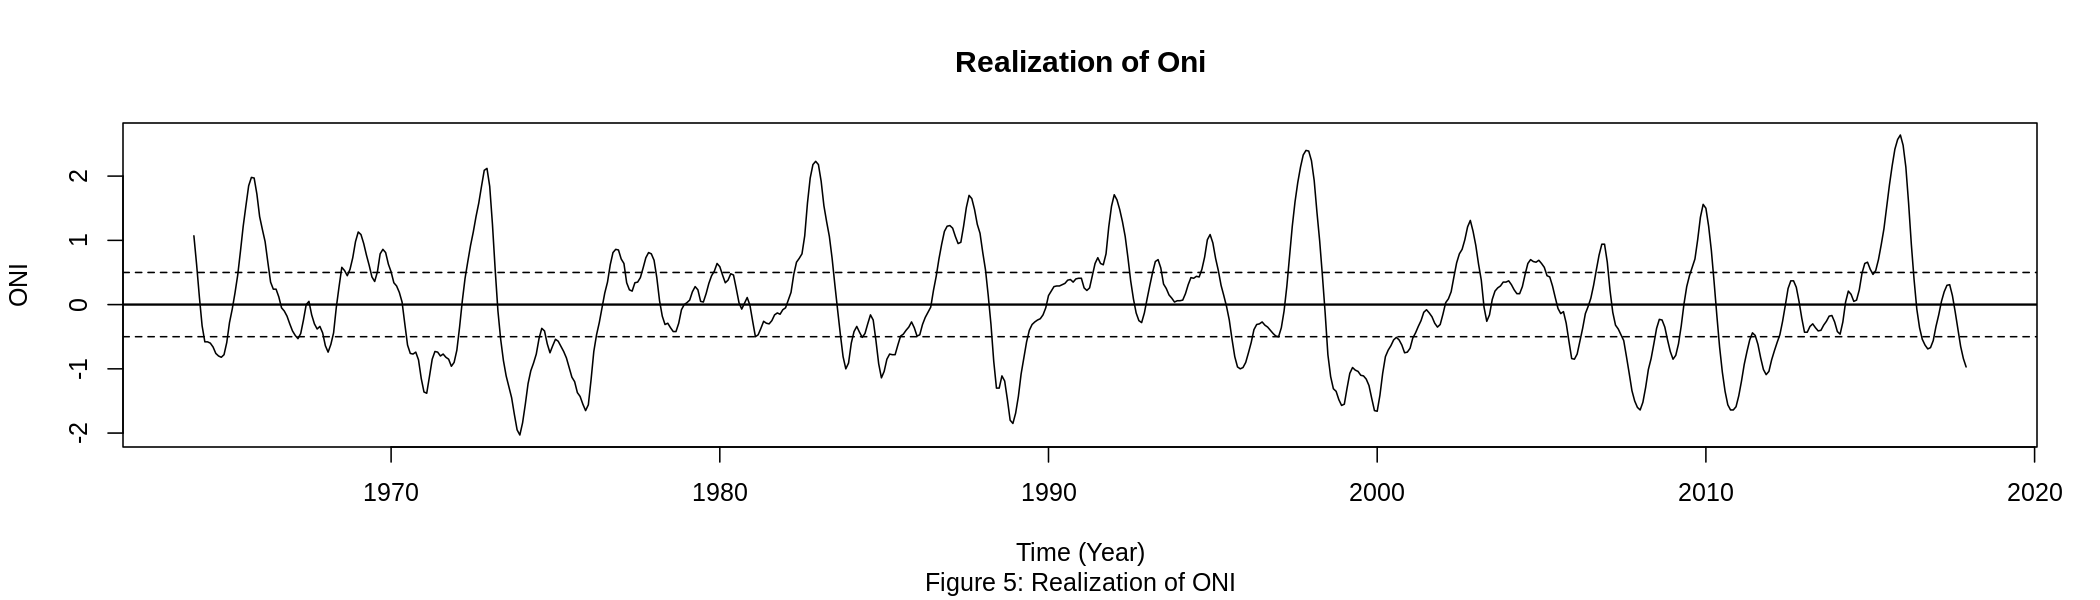

In [ ]:
elnino.ts <- ts(oni.data[which(oni.data$YR > 1963 & oni.data$YR < 2018),]$ANOM, start = 1964, freq = 12)
plot(elnino.ts, type ='l', main = 'Realization of Oni',sub = 'Figure 5: Realization of ONI', ylab = 'ONI', xlab = 'Time (Year)')

abline(h=0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

In [ ]:
# elnin.years <- unique(c(as.vector(start.years), as.vector(end.years)))
# Get El Nino Start years binarized for frequency analysis
elnin.years <- start.years
years <- c(1964:2017)

vals <- list()
for (i in 1:length(years)){
  checker = 0 

  for (j in 1:length(elnin.years)){
    if (years[i] == elnin.years[j]){
      checker <- 1
    }
  }

  if (checker == 1){
    vals[[i]] <- 1
  }

  if (checker == 0){
    vals[[i]] <- 0
  }
}

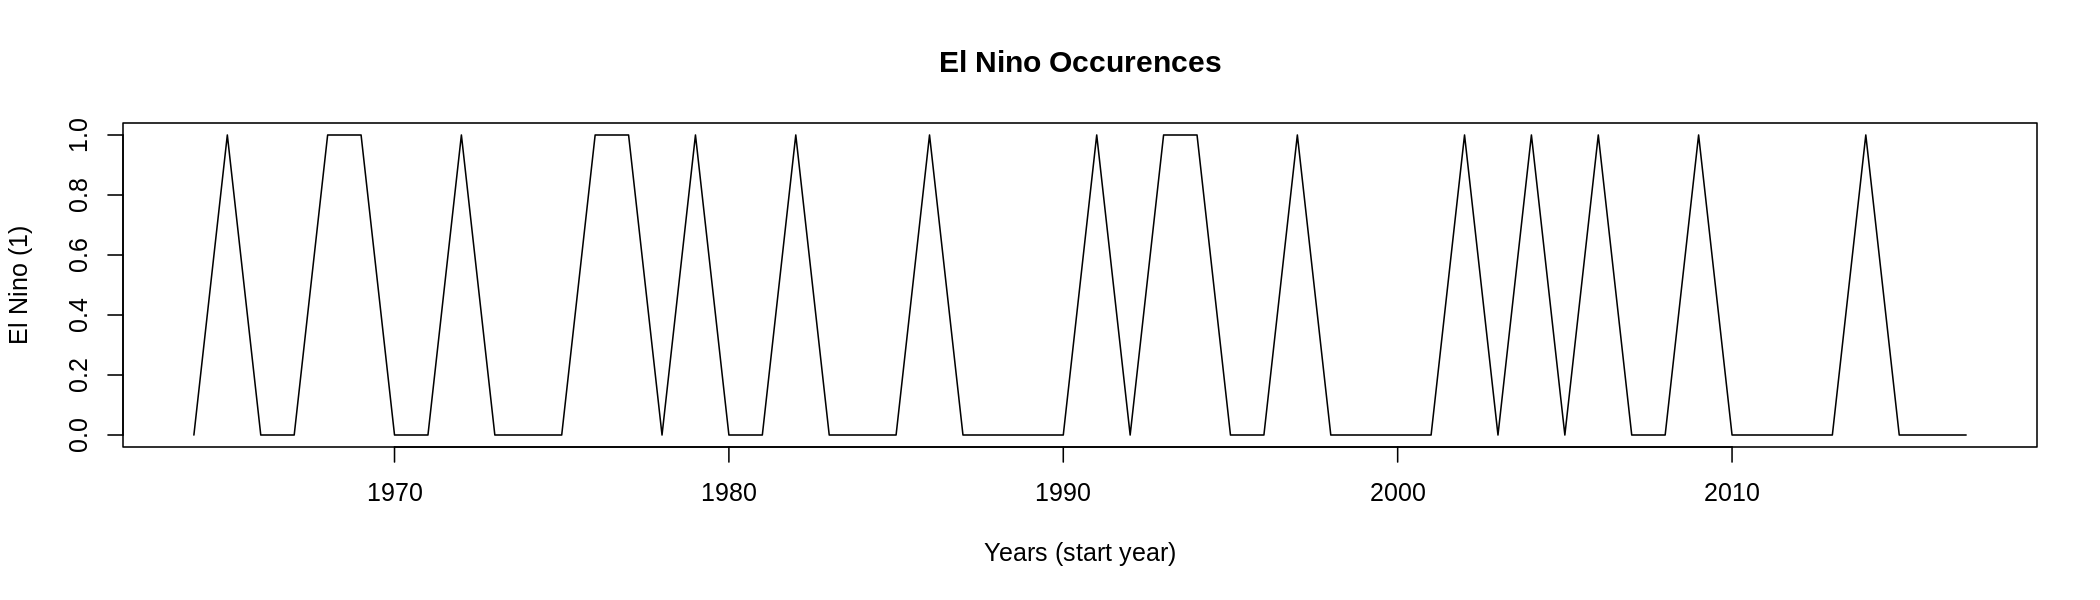

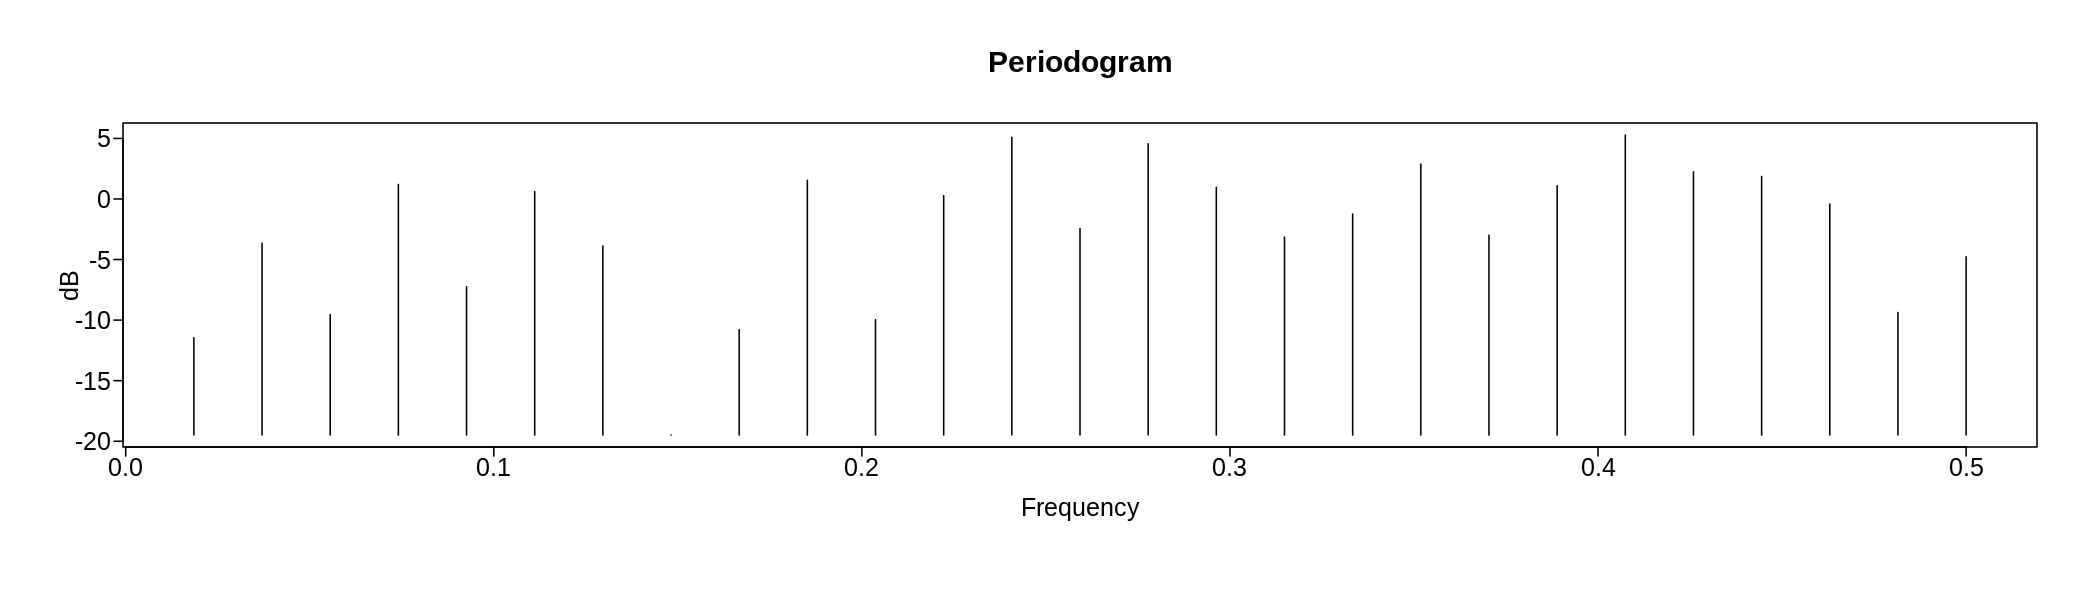

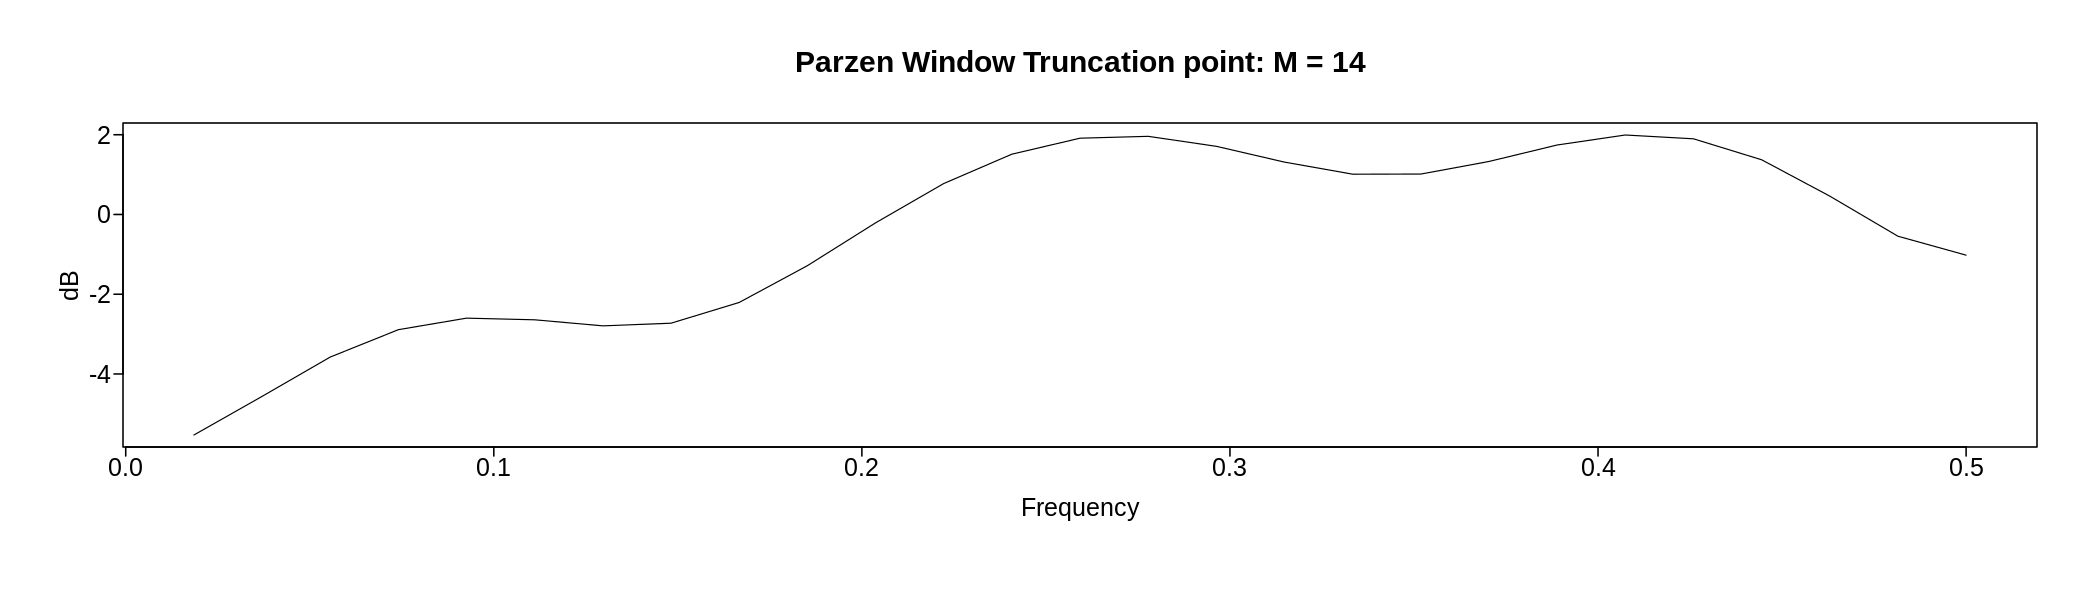

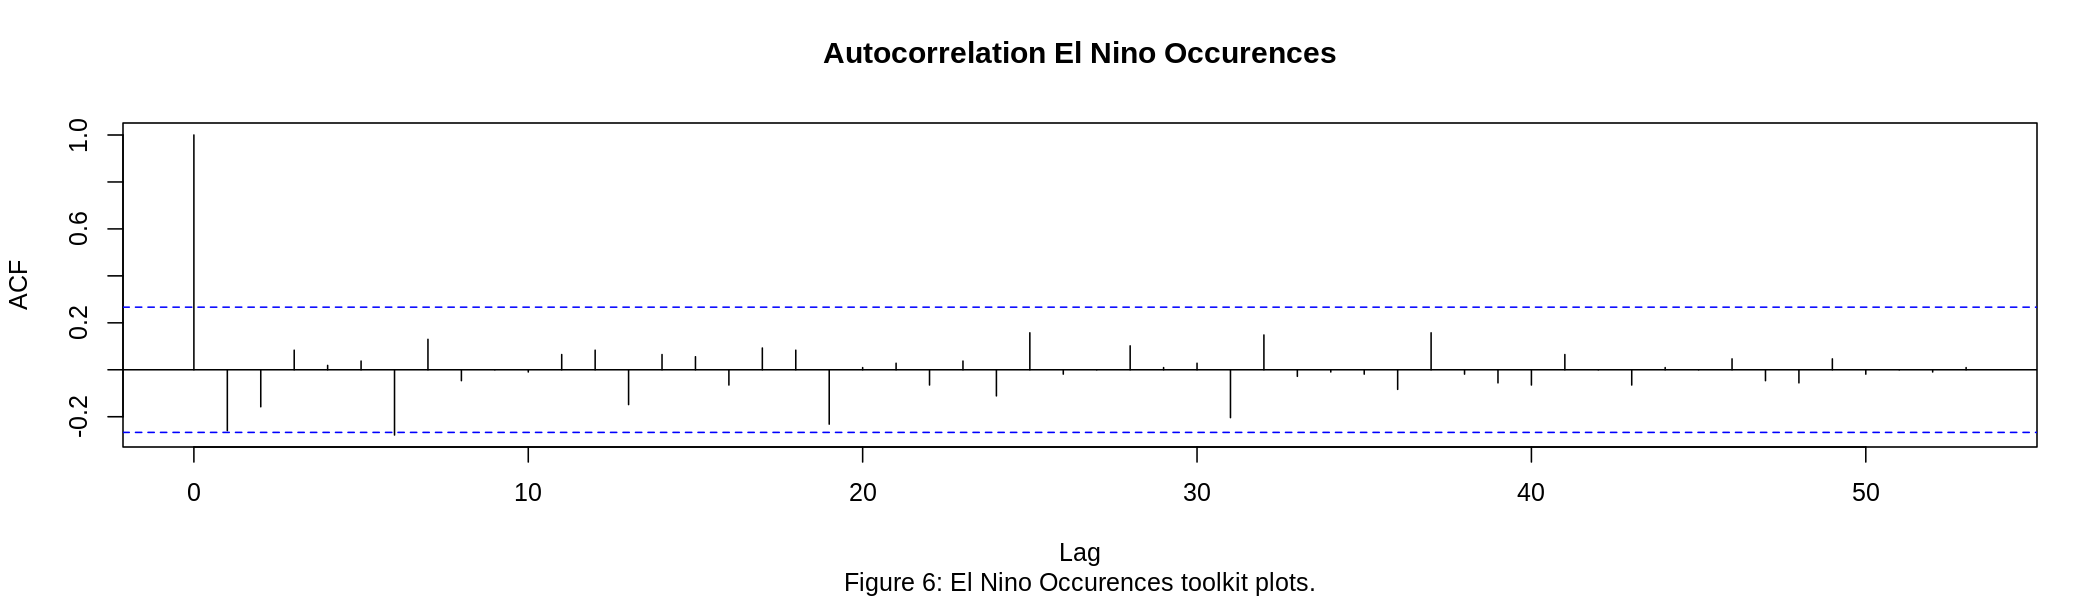

In [ ]:
ninos.ts <- ts(vals, start = 1964, frequency = 1)

plot(ninos.ts, type = 'l', xlab ='Years (start year)', ylab='El Nino (1)', main ='El Nino Occurences')
vals <- as.numeric(vals)
nino.plot <- period.wge(vals)
par.nino <- parzen.wge(vals)
acf(vals, lag.max = 80, main = 'Autocorrelation El Nino Occurences', sub = 'Figure 6: El Nino Occurences toolkit plots.')


In [ ]:
f1 <- nino.plot$freq[which.max(nino.plot$pgram)]
cat('Frequency 1: ', f1, '\n')
cat('Period 1: ', 1/f1, '\n')

pgram <- nino.plot$pgram[which(nino.plot$freq > 0 & nino.plot$freq < 0.1)]
freq <- nino.plot$freq[which(nino.plot$freq > 0 & nino.plot$freq < 0.1)]
f2 <- freq[which.max(pgram)]

cat('Frequency 2: ', f2, '\n')
cat('Period 2: ', 1/f2, '\n')

pgram <- nino.plot$pgram[which(nino.plot$freq > 0.2 & nino.plot$freq < 0.3)]
freq <- nino.plot$freq[which(nino.plot$freq > 0.2 & nino.plot$freq < 0.3)]
f3 <- freq[which.max(pgram)]

cat('Frequency 3: ', f3, '\n')
cat('Period 3: ', 1/f3, '\n')

Frequency 1:  0.4074074 
Period 1:  2.454545 
Frequency 2:  0.07407407 
Period 2:  13.5 
Frequency 3:  0.2407407 
Period 3:  4.153846 


<!-- Given the start and end date lists of El Ninos, I have then formatted these dates into a table to better understand when these El Ninos occured. -->

<!-- | Start Year | End Year |
|------------|----------|
| 1963       | 1964     |
| 1965       | 1966     |
| 1968       | 1968     |
| 1968       | 1969     |
| 1969       | 1970     |
| 1972       | 1973     |
| 1976       | 1977     |
| 1977       | 1978     |
| 1979       | 1980     |
| 1982       | 1983     |
| 1986       | 1988     |
| 1991       | 1992     |
| 1993       | 1993     |
| 1994       | 1995     |
| 1997       | 1998     |
| 2002       | 2003     |
| 2004       | 2005     |
| 2006       | 2007     |
| 2009       | 2010     |
| 2014       | 2015     |
| 2015       | 2016     | -->

<!-- From what we see in the table as well as the plot above, we can see the dotted lines showing the threshold for El Nino ($y = 0.5$) and La Nina ($y = -0.5$). The realizations going over the $y = 0.5$ threshold, since we are looking only at El Nino years, are the years identified as El Nino from the above table. -->

## 2.3 Recreate Paper Plot

Below, I recreate the plot from the paper using our loaded data sets.

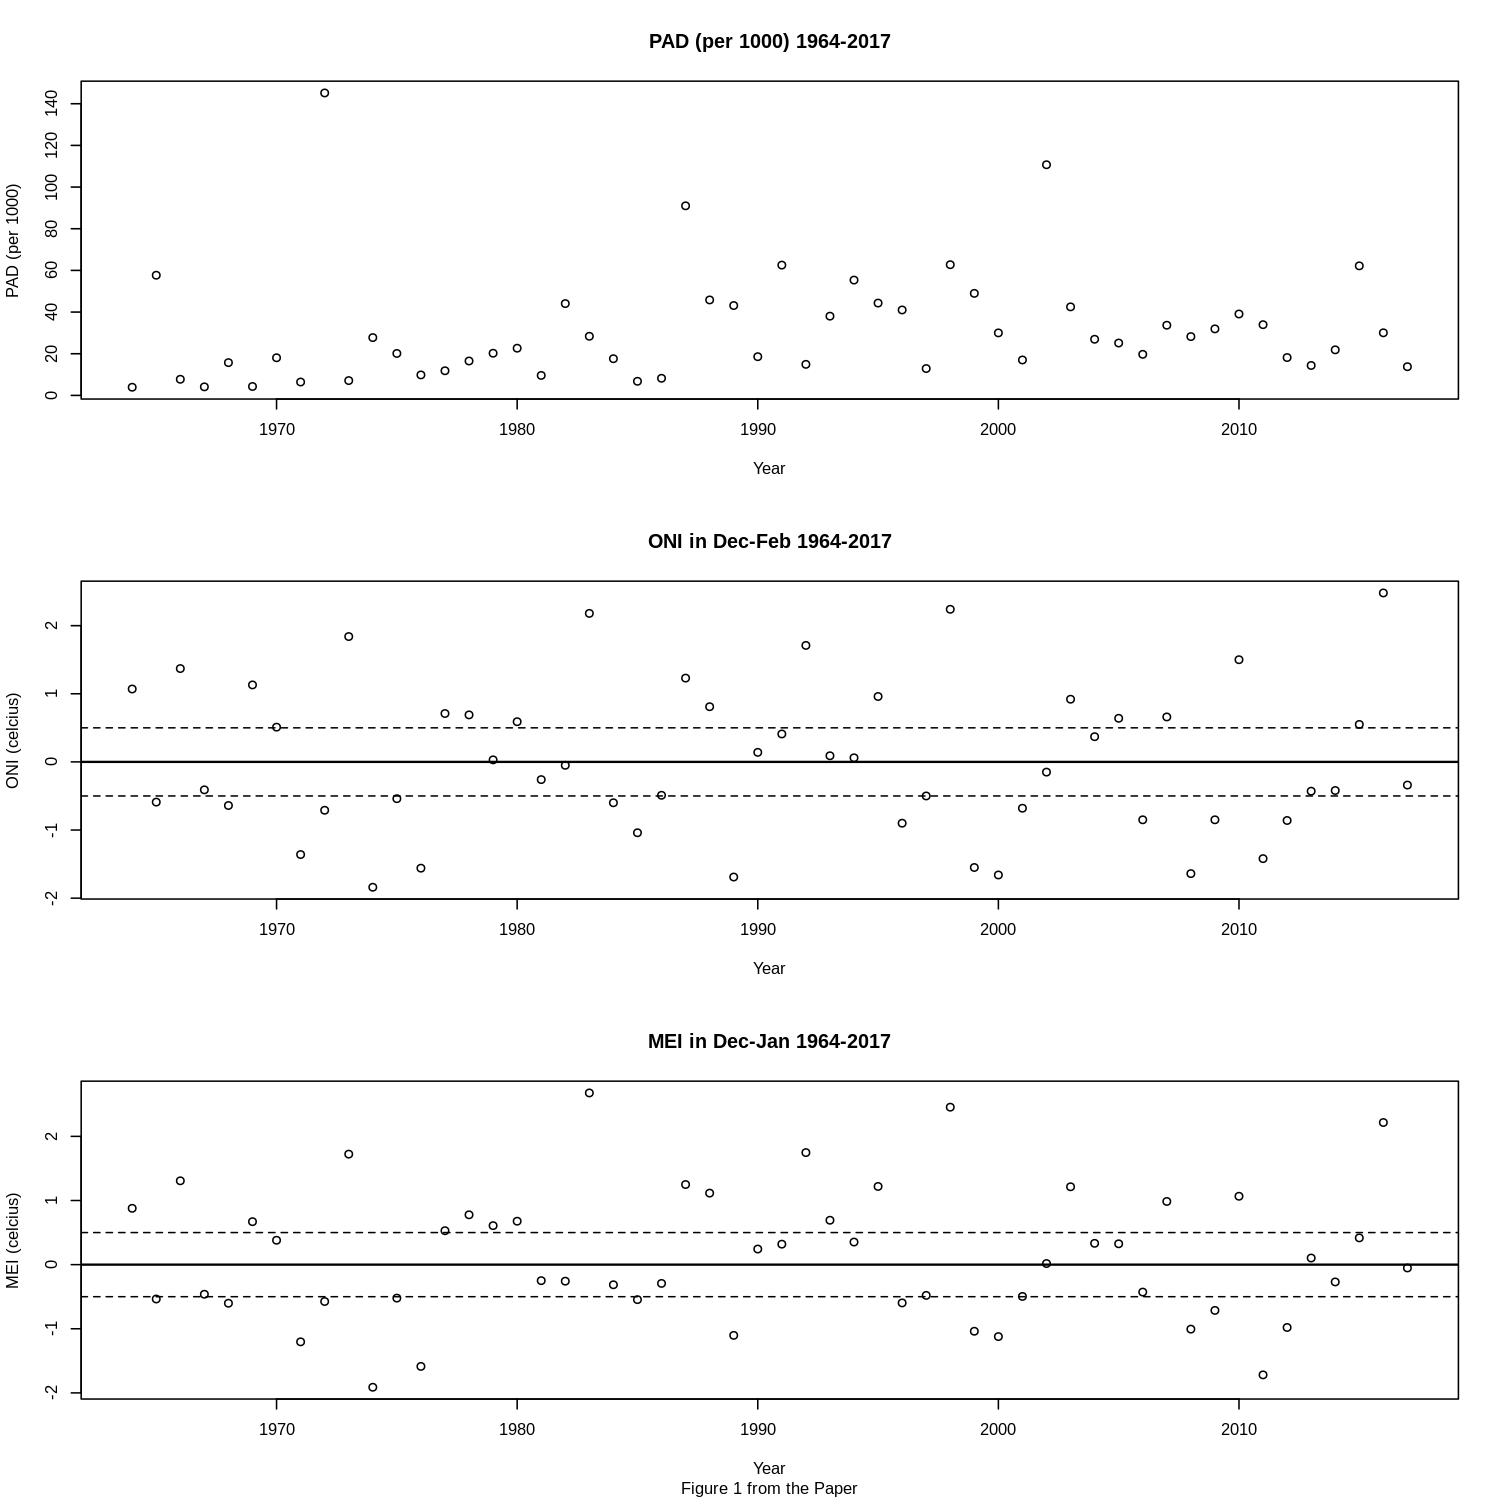

In [ ]:
# GRAPH BEGIN BELOW
par(mfrow=c(3,1))

# set options for the plot sizes 
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 150)

# plot PAD 
plot(PAD.ts,xlab = 'Year',ylab = 'PAD (per 1000)', main = 'PAD (per 1000) 1964-2017', type = 'n')
points(PAD.ts, main = 'PAD (per 1000) 1964-2017')

# Create plot of ONI and populate with points
oni.ts <- ts(subset(DJF, YR > 1963 & YR < 2018)$ANOM, start = 1964, frequency = 1)
plot(oni.ts,xlab = 'Year', ylab = 'ONI (celcius)', main='ONI in Dec-Feb 1964-2017', type = 'n')
points(oni.ts)
# Plot Constant Lines
abline(h=0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)


# Create plot of MEI and populate with points

mei.deja.ts <- ts(subset(mei.df, YEAR > 1963 & YEAR < 2018 )$DECJAN, start = 1964, frequency = 1) # MEI

plot(mei.deja.ts,xlab = 'Year',ylab = 'MEI (celcius)', main = 'MEI in Dec-Jan 1964-2017', sub = 'Figure 1 from the Paper',type = 'n')
points(mei.deja.ts, main = 'MEI in Dec-Jan 1964-2017')

# Plot Constant Lines
abline(h=0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)


# 3 Results

## 3.1 Plot from the Paper
We can combine the three plots we generated above into one figure, to recreate the figure from the paper!

![waveplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/figure1_paper.png)

## 3.2 Exploring the Data
Below, we are able to explore the plots developed from section 2.2, and see the results of our plots more concisely.

### 3.2.1 ONI - Plots
We can first look at the ONI data set. Here, we examine sea surface temperature (SST) anomalies, referred to further as anomalies. These values are a 3 month moving average. We plot the Realization, followed by the Periodogram, Parzen Window, and finally the Autocorrelation Function. 

From this, we find a periodic trend in the data of $$p = 42.607$$ meaning a periodic trend oscillating every 42.607 months.

Looking at the ACF, we can see a sinusoidal trend in the lags for a period of about 43, confirming our findings above. Furthermore, we see a rapid dampening of the autocorrelations as the lags increase.

![ONIplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/oniplots_full.png)

### 3.2.2 MEI - Plots
Next, we can look at the MEI values. We follow the same methodology of plots. The Parzen window seems to show us two peaks in the frequency. One close to 0.02, and another close to 0.18. Thus, we find the both of these frequency spikes and see $$f_1 = 0.02328 \\ f_2 = 0.1875$$ giving us then periods of $$p_1 = 42.955 \\ p_2 = 5.3333$$ This makes sense when re-examining the realization above, as we see spikes over a longer timeframe consistent with the first period being about 43 months, $p_1 = 42.947$, or about 3.6 years. Between these larger spikes, we see smaller oscillations at about every half of a year, or $p_2 = 5.333$ months.

In the Autocorrelation plot, we see a sinusoidal trend in the data that dampens fairly rapidly. We also see the period of roughly 43 manifest in one complete cycle of the sinusoidal curve.

![ONIplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/meiplots_full.png)

### 3.2.3 PAD - Plots
Now, we can look at the PAD rates to see if there is any sort of periodic behavior. From our toolkit, we are able to find three separate periods of: $$ p_1 = 2.16 \\ p_2 = 3.8571 \\ p_3 = 7.7143 $$

This indicates that we see temporal trends repeating every 2.16 years, 3.8571 years, and finally 7.7143 years. 


From the autocorrelation plot, we notice that there does not seem to to be strong correlation between points as the lag increases.

![ONIplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/padplots_full.png)

### 3.2.4 Waves - Plots
For the other data set, we employ the same set of tools and find a temporal trend within the data. This trend is seen through the periods: $$p_1 = 51.6250 \\ p_2 = 6.4531 \\ p_3 = 4.0097 \\ p_4 = 2.2692$$

Since the dataset is aggregated by weeks, we find a yearly temporal trend for period 1, as well as temporal trends around 6.453 weeks, 4.001 weeks, and 2.269 
weeks. 

The Autocorrelation plot shows us a weak sinusoidal trend repeating at about lag = 52 which concurs with our period found above. All of the ACF values are small thus indicating no strong sense of correlation between points.

This temporal trend repeated each winter makes sense, as the winter months for this buoy encounter ocean swells coming from the North/North-West direction. These N/NW swells carry much greater wave heights with them along side much colder water. To the contrary, the summer months generally bring South/South-West swells, which bring the converse; smaller wave heights and warmer water.

As for the respective shorter periods, those can be easily seen in the realization above with the oscillations with peaks between the January and December months of each year.

![waveplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/waveplots_full.png)

## 3.3 Finding El Nino Years
![onirealizplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/realization_oni.png)

The El Ninos found are formatted below where each row indicates an El Nino event.

| Table 1: El Nino Start and End Years |
|--------------------------------------|

| Start Year | End Year |
|------------|----------|
| 1963       | 1964     |
| 1965       | 1966     |
| 1968       | 1968     |
| 1968       | 1969     |
| 1969       | 1970     |
| 1972       | 1973     |
| 1976       | 1977     |
| 1977       | 1978     |
| 1979       | 1980     |
| 1982       | 1983     |
| 1986       | 1988     |
| 1991       | 1992     |
| 1993       | 1993     |
| 1994       | 1995     |
| 1997       | 1998     |
| 2002       | 2003     |
| 2004       | 2005     |
| 2006       | 2007     |
| 2009       | 2010     |
| 2014       | 2015     |
| 2015       | 2016     |


From what we see in the table as well as the plot of the ONI realization, we can see the dotted lines showing the threshold for El Nino ($y = 0.5$) and La Nina ($y = -0.5$). The realizations going over the $y = 0.5$ threshold, since we are looking only at El Nino years, are the years identified as El Ninos. 


We can plot the El Nino years by year where $y = 1$ for when an El Nino starts in a year, and $0$ otherwise. We can further apply our toolkit as seen in the figure below.

![onirealizplots](https://raw.githubusercontent.com/caiettia/Thesis-Project/main/atsa_lab1/elnino_plots.png)

From this, we find periods of: $$p_1 = 2.4545 \\ p_2 = 4.1538\\ p_3 =  13.5$$ derived from the dominant frequencies: 

$$f_1 = 0.4074 \\ f_2 = 0.2407 \\ f_3 = 0.0741$$

This tells us that there are temporal trends in El Ninos occuring every 2.45 years, 4.15 years, and 13.5 years. Looking at the autocorrelation, there does not appear to be very strong correlation between points.

# 4 Conclusion


## 4.1 Process
For the lab, I was able to download three data sets mentioned in the project, as well as a WorldBank data set for populations to be able to calculate the PAD per 1000. I then plot the realization, periodogram, parzen, and finally autocorrelations for each data set to identify temporal trends. While these tools were effective, there were certainly points where analyzing the period for example from the Parzen window was fairly challenging. Yet the tools themselves made this process easier, and thus the tools were effective in their applications. I was able to find a nearly 4-year pattern where strong spikes in ONI indicating strong El Ninos occured.

Following the identification of various trends, I further looked at the data sets and identified El Nino years based on the qualification of a set of 5 consecutive overlapping periods where the ONI >0.5 or <-0.5.

The final step in my lab was looking at another data set that could have similar temporal activity relative to the El Nino data. From this, I found the wave data set from a Buoy in Southern California, off of the Scripps Pier in San Diego. Here, I looked only at wave height and found a period consistent with my personal experience with wave heights in the region. The period of about 52 weeks is consistent with how different swells occur on the west coast and how those swells can affect wave height based on when they come.


## 4.2 Challenges
For the lab, plotting and examining the MEI and ONI was not difficult. Looking at the EMDAT data and specifically calculating the PAD was challenging. This is because joining the WorldBank population data to the EMDAT database was more challenging than expected. To overcome this, I relied on R documentation to understand what functions could assist in the dataframe cleaning and merging process.

Another challenge was identifying El Nino years. Understanding how to utilize R syntax to label and measure the lengths of time for which a given El Nino occurred based on the values of oberservations was not as straight forward as expected. The way around this was for me to assign values to each row depending on the number of consecutive rows in which an El Nino had occured using the sequence() function. Then I recorded the dates of these El Ninos based on the sequence values. 


# 5 References

- Becker, E. (2015, March 05). March 2015 ENSO DISCUSSION: El Niño is here. Retrieved February 28, 2021, from https://www.climate.gov/news-features/blogs/enso/march-2015-enso-discussion-el-ni%C3%B1o-here

- Lam, H. C. Y., Haines, A., McGregor, G., Chan, E. Y. Y., & Hajat, S. (2019). Time-series study of associations between rates of people affected by disasters and the El Niño Southern Oscillation (ENSO) cycle. International journal of environmental research and public health, 16(17), 3146.

-  Wayne Woodward (2016). tswge: Applied Time Series Analysis. R package
  version 1.0.0. https://CRAN.R-project.org/package=tswge

-   H. Wickham. Reshaping data with the reshape package. Journal of
  Statistical Software, 21(12), 2007.

- 
  R Core Team (2021). R: A language and environment for statistical
  computing. R Foundation for Statistical Computing, Vienna, Austria.
  URL https://www.R-project.org/.